# Setup the PEST(++) interface around the modified Freyberg model

In this notebook, we will construct a complex model independent (non-intrusive) interface around an existing `MODFLOW6` model using `pyEMU`. We assume that the reader is at least partially familiar with PEST(++) file formats and working philosophy. 

The modified Freyberg groundwater flow model has been constructed and is described in a previous notebook from this series. We will construct the entire PEST(++) interface from scratch here. This setup will be built upon in subsequent tutorials. 

We will rely heavily on the `pyemu.PstFrom` class. Although here we employ it with a `MODFLOW6` model, `PstFrom` is designed to be general and software independent (mostly). Some features are only available for `MODFLOW` models (e.g. `SpatialReference`).

The `PstFrom` class automates the construction of high-dimensional PEST(++) interfaces with all the bells and whistles. It provides easy-to-use functions to process model input and output files into PEST(++) datasets. It can assist with setting up spatio-temporaly varying parameters. It handles the generation of geostatisical prior covariance matrices and ensembles. It automates writting a "model run" script. It provides tools to add custom pre- and post-processing functions to this script. It makes adding tweaks and fixes to the PEST(++) interface a breeze. All of this from the comfort of your favourite Python IDE.

During this tutorial we are going to construct a PEST dataset. Amongst other things, we will demonstrate:
 - how to add observations & parameters from model output & input files;
 - how to add pre- and post-processing functions to the "model run" script;
 - how to generate geostatistical structures for spatialy and temporally correlated parameters;
 - how to edit parameter/observation data sections;
 - how to generate a prior parameter covariance matrix and prior parameter ensemble;



First, let's get our model files and sort out some admin.


### 1. Admin & Organize Folders
First some admin. Load the dependencies and organize model folders. 

In [1]:
import sys
import os
import shutil
import platform
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pyemu
import flopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

We will be calling a few external programs throughout this tutorial. Namely, MODFLOW 6 and PEST++GLM. For the purposes of the tutorial(s), we have included executables in the tutorial repository. They are in the `bin` folder. 

Preferably, executables should be located in a folder that is cited in your computer’s PATH environment variable. Doing so allows you to run them from a command prompt open to any other folder without having to include the full path to these executables in the command to run them. 

Sometimes this may not be practical. In such cases, we can simply place the executables in the folder from which they will be executed.  So, let's copy the necessary executables into our working folder:


In [2]:
# specify a temporary folder; we will gather all our model and executable files here first
# this is to ensure we don't mess up our original model files
tmp_d = os.path.join('freyberg_mf6')

# get the necessary executables; OS agnostic
bin_dir = os.path.join('..','..','bin')

if "window" in platform.platform().lower():
    exe_files = [f for f in os.listdir(bin_dir) if f.endswith('exe')]
else:
    exe_files = [f for f in os.listdir(bin_dir) if not f.endswith('exe')]

# remove existing folder if it already exists
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)

# make the folder
os.mkdir(tmp_d)

# copy executables across
for exe_file in exe_files:
    shutil.copy2(os.path.join(bin_dir, exe_file),os.path.join(tmp_d,exe_file))

Let's copy the original model folder into a new working directory, just to ensure we don't mess up the base files.

In [3]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'freyberg_mf6')

# copy files across to the temp folder
for f in os.listdir(org_d):
    shutil.copy2(os.path.join(org_d,f), os.path.join(tmp_d,f))

If you inspect the model folder, you will see that all the `MODFLOW6` model files have been written "externally". This is key for working with the `PstFrom` class (or with PEST(++) in general, really). Essentialy, all pertinent model inputs have been written as independent files in either array or list format. This makes it easier for us to programiatically access and re-write the values in these files.

Array files contain a data type (usually floating points). List files will have a few columns that contain index information and then columns of floating point values (they have a tabular format; think `.csv` files or DataFrames). The `PstFrom` class provides methods for processing these file types into a PEST(++) dataset. 



In [4]:
os.listdir(tmp_d)

['freyberg6.dis',
 'freyberg6.dis.grb',
 'freyberg6.dis_botm_layer1.txt',
 'freyberg6.dis_botm_layer2.txt',
 'freyberg6.dis_botm_layer3.txt',
 'freyberg6.dis_delc.txt',
 'freyberg6.dis_delr.txt',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.dis_idomain_layer2.txt',
 'freyberg6.dis_idomain_layer3.txt',
 'freyberg6.dis_top.txt',
 'freyberg6.ghb',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.ic',
 'freyberg6.ic_strt_layer1.txt',
 'freyberg6.ic_strt_layer2.txt',
 'freyberg6.ic_strt_layer3.txt',
 'freyberg6.ims',
 'freyberg6.lst',
 'freyberg6.nam',
 'freyberg6.npf',
 'freyberg6.npf_icelltype_layer1.txt',
 'freyberg6.npf_icelltype_layer2.txt',
 'freyberg6.npf_icelltype_layer3.txt',
 'freyberg6.npf_k33_layer1.txt',
 'freyberg6.npf_k33_layer2.txt',
 'freyberg6.npf_k33_layer3.txt',
 'freyberg6.npf_k_layer1.txt',
 'freyberg6.npf_k_layer2.txt',
 'freyberg6.npf_k_layer3.txt',
 'freyberg6.oc',
 'freyberg6.rch',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.rch_recharge_10.txt',
 'freyb

Now we need just a tiny bit of info about the spatial discretization of the model - this is needed to work out separation distances between parameters to build a geostatistical prior covariance matrix later.

Here we will load the flopy sim and model instance just to help us define some quantities later - flopy is ***not required*** to use the `PstFrom` class. ***Neither is MODFLOW***. However, at the time of writting, support for `SpatialReference` to spatially locate parameters is limited to MODLOW models.

Load the simulation. Run it once to make sure it works and to ***make sure that model output files are in the folder***. 

In [5]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_d)
# load flow model
gwf = sim.get_model()

# run the model once to make sure it works
sim.run_simulation()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package ghb...
    loading package sfr...


    loading package obs...
  loading ims package freyberg6...
FloPy is using the following executable to run the model: C:\Program Files\MODFLOW\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

   MODFLOW 6 compiled Jul 31 2021 14:57:11 with IFORT compiler (ver. 20.21.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 

    Solving:  Stress period:     2    Time step:     1
    Solving:  Stress period:     3    Time step:     1
    Solving:  Stress period:     4    Time step:     1
    Solving:  Stress period:     5    Time step:     1
    Solving:  Stress period:     6    Time step:     1
    Solving:  Stress period:     7    Time step:     1
    Solving:  Stress period:     8    Time step:     1
    Solving:  Stress period:     9    Time step:     1
    Solving:  Stress period:    10    Time step:     1
    Solving:  Stress period:    11    Time step:     1
    Solving:  Stress period:    12    Time step:     1
    Solving:  Stress period:    13    Time step:     1


    Solving:  Stress period:    14    Time step:     1
    Solving:  Stress period:    15    Time step:     1
    Solving:  Stress period:    16    Time step:     1
    Solving:  Stress period:    17    Time step:     1
    Solving:  Stress period:    18    Time step:     1
    Solving:  Stress period:    19    Time step:     1
    Solving:  Stress period:    20    Time step:     1
    Solving:  Stress period:    21    Time step:     1
    Solving:  Stress period:    22    Time step:     1
    Solving:  Stress period:    23    Time step:     1
    Solving:  Stress period:    24    Time step:     1
    Solving:  Stress period:    25    Time step:     1


 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/03/17 12:41:06
 Elapsed run time:  0.622 Seconds
 
 Normal termination of simulation.


(True, [])

### 2. Spatial Reference
Now we can instantiate a `SpatialReference`. This will later be passed to `PstFrom` to assist with spatially locating parameters (e.g. pilot points and/or cell-by-cell parameters).

In [6]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_d, "freyberg6.nam"),
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)

   could not remove start_datetime


### 3. Instantiate PstFrom

Now we can start to construct the PEST(++) interface by instantiating a `PstFrom` class instance. There are a few things that we need to specify up front:

 - the folder in which we currently have model files (e.g. `tmp_d`). PstFrom will copy all the files from this directory into a new "template" folder.
 - **template folder**: this is a folder in which the PEST dataset will be constructed. This folder/dataset will form the template for subsequent deployment of PEST(++). It is **not** where PEST(++) will be run.
 - **longnames**: for backwards compatibility with PEST and PEST_HP (i.e. non-PEST++ versions), which have upper limits to parameter/obsveration names (PEST++ does not). Setting this value to False is only recommended if required. 
 - Whether the model is `zero based` or not.
 - (optional) the **spatial reference**, as previously discussed. This is only requried if using `pyEMU` to define parameter spatial correlation. Alternatively, you can define these yourself or use utilities available in the PEST-suite. 



In [7]:
# specify a template directory (i.e. the PstFrom working folder)
template_ws = os.path.join("freyberg6_template")

# instantiate PstFrom
pf = pyemu.utils.PstFrom(original_d=tmp_d, # where the model is stored
                            new_d=template_ws, # the PEST template folder
                            remove_existing=True, # ensures a clean start
                            longnames=True, # set False if using PEST/PEST_HP
                            spatial_reference=sr, #the spatial reference we generated earlier
                            zero_based=False, # does the MODEL use zero based indices? For example, MODFLOW does NOT
                            start_datetime="1-1-2018") # required when specifying temporal correlation between parameters

2022-03-17 12:41:06.287890 starting: opening PstFrom.log for logging
2022-03-17 12:41:06.288876 starting PstFrom process
2022-03-17 12:41:06.289898 starting: setting up dirs
2022-03-17 12:41:06.289898 starting: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template'


2022-03-17 12:41:07.088736 finished: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template' took: 0:00:00.798838
2022-03-17 12:41:07.089733 finished: setting up dirs took: 0:00:00.799835


### 4. Observations

We now have a `PstFrom` instance assigned to the variable `pf`. For now it is only an empty container to which we can start adding "observations", "parameters" and other bits and bobs.

Lets start with observations because they are easier. `MODFLOW6` makes life even easier by recording observations in nicely organized .csv files. Isn't that a peach!

#### 4.1 Freyberg Recap
As you may recall from the "*intro to Freyberg*" tutorial, the model is configured to record time series of head at observation wells, and flux at three locations along the river. These are recorded in external .csv files named `heads.csv` and `sfr.csv`, respectively. You should be able to see these files in the model folder.

Recall that each .csv houses records of observation time-series. Outputs are recorded for each simulated stress-period. The model starts with a single steady-state stress-period, followed by 24 monthly transient stress-periods. The steady-state and first 12 transient stress-periods simulate the history-matching period. The last 12 transient stress periods simulate future conditions (i.e. the prediction period).

In [8]:
# check the output csv file names
for i in gwf.obs:
    print(i.output.obs_names)

['sfr.csv']
['heads.csv']


Let's start with the 'heads.csv' file. First load it as a DataFrame to take a look.

As you can see, there are many columns, one for each observation site. Conveniently, * *cough* * they are named according to the cell layer, row and column. Note that at every site, there is an observation in both the top and bottom layer (0_ and 2_). We will make use of this later to create "secondary observations" of head differences between layers...but let's not get distracted.

The values in the *.csv* file were generated by running the model. (***IMPORTANT!***) However, `PstFrom` assumes that values in this file are the *target* observation values, and they will be used to populate the PEST(++) dataset. Now, you can change these values later on if you wish. However, it can get a bit messy. So you either need to populate model output files with the target values, or update values in the PEST(++) dataset later on. Which approach you adopt is up to personal preference and/or specifics of your modelling workflow. 

We will demonstrate both in this notebook.

In [9]:
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)
df.head()

,TRGW_2_2_15,TRGW_2_2_9,TRGW_2_3_8,TRGW_2_9_1,TRGW_2_13_10,TRGW_2_15_16,TRGW_2_21_10,TRGW_2_22_15,TRGW_2_24_4,TRGW_2_26_6,...,TRGW_0_9_1,TRGW_0_13_10,TRGW_0_15_16,TRGW_0_21_10,TRGW_0_22_15,TRGW_0_24_4,TRGW_0_26_6,TRGW_0_29_15,TRGW_0_33_7,TRGW_0_34_10
time,,,,,,,,,,,,,,,,,,,,,
1.0,34.339320,34.581597,34.611207,34.872171,34.257574,34.136387,34.144465,34.027679,34.310857,34.171589,...,34.878082,34.263187,34.141599,34.150067,33.992380,34.316575,34.177206,33.909874,33.985755,33.890192
32.0,34.422684,34.680896,34.712058,34.973141,34.381609,34.245718,34.272721,34.138233,34.437640,34.313791,...,34.978998,34.386488,34.250497,34.277455,34.087585,34.442526,34.318135,33.992787,34.102892,34.005675
61.0,34.496186,34.778508,34.812111,35.083708,34.481942,34.330460,34.376598,34.219319,34.555036,34.427653,...,35.089608,34.487850,34.336217,34.382375,34.158109,34.560492,34.433115,34.058266,34.196067,34.086361
92.0,34.541607,34.848735,34.885189,35.178103,34.536194,34.372437,34.431944,34.257802,34.631805,34.490964,...,35.184255,34.543248,34.379139,34.438943,34.191730,34.638273,34.497733,34.090937,34.244095,34.121186
122.0,34.538213,34.859840,34.898354,35.214761,34.520171,34.353363,34.414553,34.236799,34.634051,34.476152,...,35.221267,34.528011,34.360599,34.422425,34.173799,34.641451,34.483960,34.076498,34.226023,34.095425


#### 4.2 Prepare Observation Files

We will start by populating our "model output" file with measured values. For this synthetic case, we conveniently have observations for all model output times and sites. (These "measured" values were generated using the same model with a randomly generated set of parameters; noise was added to all observations.)

In the next cell we read a .csv that contains measured obsevration values. As it has the exact same structure as our model output file, we can simpy replace the values in the model output file (and re-write it!). In real-world cases this step will likley be a bit more involved.

In [10]:
# read the measured head values
hds_meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"heads.meas.csv"),
                    index_col=0)

# re-write the model output .csv file with the measured values
hds_meas.to_csv(os.path.join(template_ws,"heads.csv"))

#### 4.2. Adding Observations

Now that our model output file contains the "target values", we can use the `PstFrom.add_observations()` method to add observations to our `pf` object. This method reads ***list-type*** files. The assumption is that these files are organized in a tabular format. 

We are going to tell `pf` which columns of this file contain observations. Values in these columns will be assigned to *observation values*.

We can also inform it if there is an index column. Values in this column will be included in the *observation names*. 

We could also specify which rows to include as observations. But observations are free...so why not keep them all! 

Let's add observations from `heads.csv`. The first column of this file records the time at which the value is simulated. Let's use that as the index column (this becomes useful later on to post-process results). We want all other columns as observation values.


In [11]:
hds_df = pf.add_observations("heads.csv", # the model output file to read
                            insfile="heads.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hds") #prefix to all observation names; choose something logical and easy o find. We use it later on to select obsevrations

2022-03-17 12:41:07.145617 starting: adding observations from output file heads.csv
2022-03-17 12:41:07.145617 starting: adding observations from tabular output file '['heads.csv']'
2022-03-17 12:41:07.146584 starting: reading list-style file: freyberg6_template\heads.csv
2022-03-17 12:41:07.152601 finished: reading list-style file: freyberg6_template\heads.csv took: 0:00:00.006017
2022-03-17 12:41:07.153601 starting: building insfile for tabular output file heads.csv
2022-03-17 12:41:07.162572 finished: building insfile for tabular output file heads.csv took: 0:00:00.008971
2022-03-17 12:41:07.162572 starting: adding observation from instruction file 'freyberg6_template\heads.csv.ins'
2022-03-17 12:41:07.180526 finished: adding observation from instruction file 'freyberg6_template\heads.csv.ins' took: 0:00:00.017954
2022-03-17 12:41:07.181489 finished: adding observations from tabular output file '['heads.csv']' took: 0:00:00.035872


Let's inspect what we just created. 

We can see that the `.add_observations()` method returned a dataframe with lots of useful info: 

 - the observation names that were formed (see `obsnme` column); note that these inlcude lots of usefull metadata like the column name, index value and so on;
 - the values that were read from `heads.csv` (see `obsval` column); 
 - some generic weights and group names; note that observations are grouped according to the column of the model output .csv. Alternatively, we could have specified a list of observation group names.

In [12]:
hds_df.head()

,obsnme,obsval,weight,obgnme
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450661,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441799,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375622,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323056,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10


At this point, no PEST *control file* has been created, we have simply prepared to add these observations to the control file later. Everything is still only stored in memory. However, a PEST *instruction* file has been created in the template folder (`template_ws`):

In [13]:
[f for f in os.listdir(template_ws) if f.endswith(".ins")]

['heads.csv.ins']

Blimey, wasn't that easy? Automatically assimilating thousands of observations into a PEST dataset becomes a breeze!

Let's quickly do the same thing for the SFR observations.

In [14]:
df = pd.read_csv(os.path.join(template_ws, "sfr.csv"), index_col=0)
df.head()

,HEADWATER,TAILWATER,GAGE_1
time,,,
1.0,-644.10,-477.76,1205.3
32.0,-865.29,-638.26,1636.6
61.0,-1034.00,-764.91,1938.5
92.0,-1118.70,-825.49,2073.6
122.0,-1083.00,-794.89,1983.4


In [15]:
# read the measured  values
meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"sfr.meas.csv"),
                    index_col=0)
# re-write the model output .csv file with the measured values
meas.to_csv(os.path.join(template_ws,"sfr.csv"))
# add the observations to pf
sfr_df = pf.add_observations("sfr.csv", # the model output file to read
                            insfile="sfr.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfr") #prefix to all observation names

2022-03-17 12:41:07.225410 starting: adding observations from output file sfr.csv
2022-03-17 12:41:07.225410 starting: adding observations from tabular output file '['sfr.csv']'
2022-03-17 12:41:07.226369 starting: reading list-style file: freyberg6_template\sfr.csv
2022-03-17 12:41:07.228363 finished: reading list-style file: freyberg6_template\sfr.csv took: 0:00:00.001994
2022-03-17 12:41:07.228363 starting: building insfile for tabular output file sfr.csv
2022-03-17 12:41:07.235346 finished: building insfile for tabular output file sfr.csv took: 0:00:00.006983
2022-03-17 12:41:07.235346 starting: adding observation from instruction file 'freyberg6_template\sfr.csv.ins'
2022-03-17 12:41:07.244321 finished: adding observation from instruction file 'freyberg6_template\sfr.csv.ins' took: 0:00:00.008975
2022-03-17 12:41:07.245318 finished: adding observations from tabular output file '['sfr.csv']' took: 0:00:00.019908


### 5. Parameters

The `PstFrom.add_parameters()` method reads model input files and adds parameters to the PEST(++) dataset. Parameterisation can be configured in several ways. 

 - model input files can be in array or list format;
 - parameters can be setup as different "types". Values in model input files can (1) each be a separate parameter, (2) be grouped into "zones" or (3) all be treated as a single parameter. Alteratvely, (4) parameters can be assigned to pilot points, from which individual parameter values are subsequently interpolated. `PstFrom` adds the relevant pre-processing steps to assign paramter values directly into the "model run" script.
 - parameter values can be setup as "direct", "multiplier" or "addend". This means the "parameter value" which PEST(++) sees can be (1) the same value the model sees, (2) a multiplier on the value in the model input file, or (3) a value which is added to the value in the model input file. This is very nifty. `PstFrom` is designed to preferentially use parameters setup as multipliers. These let us preserve the existing model inputs and treat them as the mean of the prior parameter distribution. Once again, relevant pre-processing scripts are automatically added to the "model run" script (discussed later).


#### 5.1. Freyberg Recap

As discussed, all model inputs are stored in external files. Some are arrays. Others are lists. Recall that our model has 3 layers. It is transient. Hydraulic properties (Kh, Kv, Ss, Sy) vary in space. Recharge varies over both space and time. We have GHBs, SFR and WEL boundary conditions. GHB parameters are constant over time, but vary spatially. SFR inflow varies over time. Pumping rates of individual wells are uncertain in space and and time.

All of these have some degree of spatial and/or temporal correlation.

#### 5.2. Geostatistical Structures

Parameter correlation plays a role in (1) regularization when giving preference to the emergence of patterns of spatial heterogeneity and (2) when specifying the prior parameter probability distribution. Since we are all sophisticated and recognize the importance of expressing spatial and temporal uncertainty (e.g. heterogeneity) in the model inputs (and the corresponding spatial correlation in those uncertain inputs), let's use geostatistics to express uncertainty. To do that we need to define "geostatistical structures". 

For the sake of this tutorial, let's assume that heterogeneity in all spatially distributed parameters share the same statistical characteristics. Likewise for temporally varying parameters. We will therefore only  construct two geostatisitcal structures.

<AxesSubplot:xlabel='distance', ylabel='$\\gamma$'>

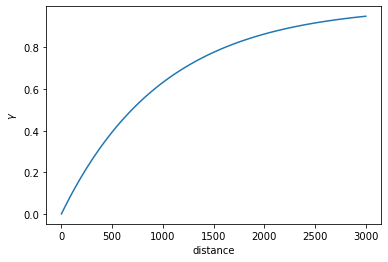

In [16]:
# exponential variogram for spatially varying parameters
v_space = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=1000, # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
grid_gs = pyemu.geostats.GeoStruct(variograms=v_space, transform='log') 

# plot the gs if you like:
grid_gs.plot()

In [17]:
# exponential variogram for time varying parameters
v_time = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=60, # range of correlation; length time units (days)
                                    anisotropy=1.0, #do not change for 1-D time
                                    bearing=0.0 #do not change for 1-D time
                                    )

# geostatistical structure for time varying parameters
temporal_gs = pyemu.geostats.GeoStruct(variograms=v_time, transform='none') 

#### 5.3. Add Parameters

Let's start by adding parameters of hydraulic properties that vary in space (but not time) and which are housed in array-type files (e.g. Kh, Kv, Ss, Sy). We will start by demonstrating step-by-step for Kh.

First, find all the external array files that contain Kh values. In our case, these are the files with "npf_k_" in the file name. As you can see below, there is one file for each model layer. 

In [18]:
tag = "npf_k_"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.npf_k_layer1.txt', 'freyberg6.npf_k_layer2.txt', 'freyberg6.npf_k_layer3.txt']


Let's setup multiple spatial scales of parameters for Kh. To do this we will use three of the parameter "types" described above. The coarse scale will be a `constant` single value for each array. The medium scale will `pilot points`. The finest scale will use parameters as the `grid` scale (a unique parameter for each model cell!)

Each scale of parameters will work with the others as multipliers with the existing Kh arrays. (This all happens at runtime as part of the "model run" script.) Think of the scales as dials that PEST(++) can turn to improve the fit. The "coarse" scale is one big dial that alows PEST to move everything at once. The "medium" dials are few (but not too many) that allow PEST to adjust broad areas, but not making eveything move. The "fine" scales are lots of small dials that allow PEST(++) to have very detailed control, tweaking parameter values within very small areas. 

However, because we are working with parameter `multipliers`, we will need to specify two sets of parameter bounds: 
 - `upper_bound` and `lower_bound` are the standard control file bounds, while
 - `ult_ubound` and `ult_lbound` are bounds that are applied at runtime to the resulting (multiplied out) model input array. 
 
Since we are using sets of multipliers, it is important to make sure we keep the resulting model input arrays within the range of realistic values.

#### 5.3.1. Array Files

We will first demonstrate steb-by-step for `freyberg6.npf_k_layer1.txt`. We will start with grid scale parameters. These are multipliers assigned to each individual value in the array.

We start by getting the idomain array. As our model has inactive cells, this heps us avoid adding unncessary parameters. It is also required later when generating pilot points.

In [19]:
# as IDOMIAN is the same in all layers, we can use any layer
ib = gwf.dis.idomain.get_data(layer=0)

In [20]:
f = 'freyberg6.npf_k_layer1.txt'

# grid (fine) scale parameters
df_gr = pf.add_parameters(f,
                zone_array=ib, #as we have inactie model cells, we can avoid assigning these as parameters
                par_type="grid", #specify the type, these will be unique parameters for each cell
                geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                lower_bound=0.2, upper_bound=5.0, #parameter lower and upper bound
                ult_ubound=100, ult_lbound=0.01 # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                )

2022-03-17 12:41:07.582610 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-17 12:41:07.583608 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-17 12:41:07.589648 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.006040
2022-03-17 12:41:07.589648 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-17 12:41:07.591587 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:07.591587 starting: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0']
2022-03-17 12:41:07.603554 finished: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0'] took: 0:00:00.011967
2022-03-17 12:41:07.604552 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2022-0

As when adding observations,  `pf.add_parameters()` returns a dataframe. Take a look. You may recognize alot of the information that appears in a PEST `*parameter data` section. All of this is still only housed in memory for now. We will write the PEST control file later on.

In [21]:
df_gr.head()

,parnme,parval1,i,j,x,y,pargp,tpl_filename,input_filename,partype,partrans,parubnd,parlbnd,parchglim,dercom,offset,scale
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,1.0,0,0,125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,factor,1,0.0,1.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,1.0,0,1,375.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,factor,1,0.0,1.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,1.0,0,2,625.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,factor,1,0.0,1.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,1.0,0,3,875.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,factor,1,0.0,1.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,1.0,0,4,1125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,factor,1,0.0,1.0


Now, we add pilot point (medium scale) multiplier parameters to the same model input file. These multipliers are assigned to pilot points, which are subsequently interpolated to values in the array.

You can add pilot points in two ways:

1. `PstFrom` can generate them for you on a regular grid or 
2. you can supply `PstFrom` with existing pilot point location information. 

When you change `par_type` to "pilotpoints", by default, a regular grid of pilot points is setup using a default `pp_space` value of 10 (which is every 10th row and column). You can chnge this spacing by passing a integer to `pp_space` (as demonstrated below). 

Alternatively you can specify a filename or dataframe with pilot point locations. If you supply `pp_space` as a `str` it is assumed to be a filename. The extension is the guide: ".csv" for dataframe, ".shp" for shapefile (point-type). Anything else and the file is assumed to be a pilot points file type. The dataframe (or .csv file) must have "name", "x", and "y" as columns - it can have more, but must have those. 

In [22]:
# pilot point (medium) scale parameters
df_pp = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="pilotpoints",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_pp",
                    pargp=f.split('.')[1]+"_pp",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01,
                    pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

2022-03-17 12:41:07.638461 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-17 12:41:07.639642 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-17 12:41:07.641454 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.001812
2022-03-17 12:41:07.641454 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-17 12:41:07.642450 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_pp_inst0_pilotpoints.csv.tpl'
2022-03-17 12:41:07.642450 starting: setting up pilot point parameters
2022-03-17 12:41:07.642450 No spatial reference (containing cell spacing) passed.
2022-03-17 12:41:07.642450 OK - using spatial reference in parent object.
2022-03-17 12:41:07.720643 32 pilot point parameters created
2022-03-17 12:41:07.721640 pilot point 'pargp':npf_k_layer1_pp
2022-03-17 12:41:07.721640 finished: setting up pilot point parameters took: 

starting 0


starting 1


starting 2


starting 3


starting 4


starting 5


starting 6


starting 7


starting 8


starting 9


took 16.178139 seconds
2022-03-17 12:41:23.951606 finished: calculating factors for pargp=npf_k_layer1_pp took: 0:00:16.223983
2022-03-17 12:41:23.951606 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_pp_inst0pp.dat.tpl'
2022-03-17 12:41:23.951606 saving zone array freyberg6_template\npf_k_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer1_pp_inst0pp.dat.tpl
2022-03-17 12:41:23.957590 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt'] took: 0:00:16.319129


Lastly, add the constant (coarse) parameter multiplier. This is a single multiplier value applied to all values in the array. 

In [23]:
# constant (coarse) scale parameters
df_cst = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="constant",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_cn",
                    pargp=f.split('.')[1]+"_cn",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01)

2022-03-17 12:41:23.964605 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-17 12:41:23.964605 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-17 12:41:23.966567 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.001962
2022-03-17 12:41:23.966567 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-17 12:41:23.967597 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl'
2022-03-17 12:41:23.968562 starting: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_layer1_cn_inst:0']
2022-03-17 12:41:23.975543 finished: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_layer1_cn_inst:0'] took: 0:00:00.006981
2022-03-17 12:41:23.976540 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_cn_inst0_cons

Let's do that for Kh in the other layers. We are going to be doing this a few times, so lets write a function.

In [24]:
def add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100):
    # grid (fine) scale parameters
    pf.add_parameters(f,
                    zone_array=ib,
                    par_type="grid", #specify the type, these will be unique parameters for each cell
                    geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                    par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                    pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                    lower_bound=lb, upper_bound=ub, #parameter lower and upper bound
                    ult_ubound=uub, ult_lbound=ulb # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                    )
                    
    # pilot point (medium) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="pilotpoints",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_pp",
                        pargp=f.split('.')[1]+"_pp",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb,
                        pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

    # constant (coarse) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_cn",
                        pargp=f.split('.')[1]+"_cn",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb)
    return

In [25]:
for f in files[1:]:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

2022-03-17 12:41:23.998482 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt']
2022-03-17 12:41:23.999521 starting: loading array freyberg6_template\freyberg6.npf_k_layer2.txt
2022-03-17 12:41:24.006463 finished: loading array freyberg6_template\freyberg6.npf_k_layer2.txt took: 0:00:00.006942
2022-03-17 12:41:24.006463 loaded array 'freyberg_mf6\freyberg6.npf_k_layer2.txt' of shape (40, 20)
2022-03-17 12:41:24.009452 starting: writing array-style template file 'freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:24.009452 starting: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k_layer2_gr_inst:0']
2022-03-17 12:41:24.023415 finished: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k_layer2_gr_inst:0'] took: 0:00:00.013963
2022-03-17 12:41:24.023415 starting: writing array-based template file 'freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl'
2022-0

2022-03-17 12:41:24.111180 32 pilot point parameters created
2022-03-17 12:41:24.111180 pilot point 'pargp':npf_k_layer2_pp
2022-03-17 12:41:24.111180 finished: setting up pilot point parameters took: 0:00:00.075765
2022-03-17 12:41:24.118162 starting: writing array-based template file 'freyberg6_template\npf_k_layer2_pp_inst0pp.dat.tpl'
2022-03-17 12:41:24.118162 saving zone array freyberg6_template\npf_k_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer2_pp_inst0pp.dat.tpl
2022-03-17 12:41:24.156094 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt'] took: 0:00:00.124668
2022-03-17 12:41:24.156094 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt']


2022-03-17 12:41:24.156094 starting: loading array freyberg6_template\freyberg6.npf_k_layer2.txt
2022-03-17 12:41:24.158055 finished: loading array freyberg6_template\freyberg6.npf_k_layer2.txt took: 0:00:00.001961
2022-03-17 12:41:24.158055 loaded array 'freyberg_mf6\freyberg6.npf_k_layer2.txt' of shape (40, 20)
2022-03-17 12:41:24.160050 starting: writing array-style template file 'freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl'
2022-03-17 12:41:24.160050 starting: writing template file freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl for ['npf_k_layer2_cn_inst:0']
2022-03-17 12:41:24.167074 finished: writing template file freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl for ['npf_k_layer2_cn_inst:0'] took: 0:00:00.007024
2022-03-17 12:41:24.168029 starting: writing array-based template file 'freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl'
2022-03-17 12:41:24.168029 saving zone array freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.zone fo

2022-03-17 12:41:24.181019 finished: loading array freyberg6_template\freyberg6.npf_k_layer3.txt took: 0:00:00.005976
2022-03-17 12:41:24.182015 loaded array 'freyberg_mf6\freyberg6.npf_k_layer3.txt' of shape (40, 20)
2022-03-17 12:41:24.183012 starting: writing array-style template file 'freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:24.183986 starting: writing template file freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl for ['npf_k_layer3_gr_inst:0']
2022-03-17 12:41:24.195985 finished: writing template file freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl for ['npf_k_layer3_gr_inst:0'] took: 0:00:00.011999
2022-03-17 12:41:24.195985 starting: writing array-based template file 'freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:24.195985 saving zone array freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl
2022-03-17 12:41:24.202934 finished: adding grid typ

2022-03-17 12:41:24.283753 saving zone array freyberg6_template\npf_k_layer3_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer3_pp_inst0pp.dat.tpl
2022-03-17 12:41:24.289714 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt'] took: 0:00:00.086780
2022-03-17 12:41:24.289714 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt']
2022-03-17 12:41:24.289714 starting: loading array freyberg6_template\freyberg6.npf_k_layer3.txt
2022-03-17 12:41:24.291731 finished: loading array freyberg6_template\freyberg6.npf_k_layer3.txt took: 0:00:00.002017
2022-03-17 12:41:24.291731 loaded array 'freyberg_mf6\freyberg6.npf_k_layer3.txt' of shape (40, 20)
2022-03-17 12:41:24.292729 starting: writing array-style template file 'freyberg6_template\npf_k_layer3_cn_inst0_constant.csv.tpl'
2022-03-17 12:41:24.293741 starting: writing template file freyberg6_template\npf_k_layer3_cn_inst0_constant.csv.tpl for ['npf_k_

Well...hot damn, wasn't that easy? Let's speed through the other array parameter files.

In [26]:
# for Kv
tag = "npf_k33"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

# for Ss
tag = "sto_ss"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 2 and 3; we aren't monsters
for f in files[1:]: 
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=1e-6, uub=1e-3)

# For Sy
tag = "sto_sy"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 1
f = files[0]
add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=0.4)


2022-03-17 12:41:24.317628 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt']
2022-03-17 12:41:24.317628 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt
2022-03-17 12:41:24.324713 finished: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt took: 0:00:00.007085
2022-03-17 12:41:24.324713 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer1.txt' of shape (40, 20)
2022-03-17 12:41:24.326656 starting: writing array-style template file 'freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:24.326656 starting: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl for ['npf_k33_layer1_gr_inst:0']
2022-03-17 12:41:24.339624 finished: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl for ['npf_k33_layer1_gr_inst:0'] took: 0:00:00.012968
2022-03-17 12:41:24.339624 starting: writing array-based template file 'freyberg6_template\npf_k33_layer1_gr_inst0_

2022-03-17 12:41:24.347639 finished: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt'] took: 0:00:00.030011
2022-03-17 12:41:24.347639 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt']
2022-03-17 12:41:24.347639 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt
2022-03-17 12:41:24.348632 finished: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt took: 0:00:00.000993
2022-03-17 12:41:24.348632 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer1.txt' of shape (40, 20)
2022-03-17 12:41:24.350627 starting: writing array-style template file 'freyberg6_template\npf_k33_layer1_pp_inst0_pilotpoints.csv.tpl'
2022-03-17 12:41:24.350627 starting: setting up pilot point parameters
2022-03-17 12:41:24.350627 No spatial reference (containing cell spacing) passed.
2022-03-17 12:41:24.350627 OK - using spatial reference in parent object.


2022-03-17 12:41:24.420457 32 pilot point parameters created
2022-03-17 12:41:24.420457 pilot point 'pargp':npf_k33_layer1_pp
2022-03-17 12:41:24.420457 finished: setting up pilot point parameters took: 0:00:00.069830
2022-03-17 12:41:24.427439 starting: writing array-based template file 'freyberg6_template\npf_k33_layer1_pp_inst0pp.dat.tpl'
2022-03-17 12:41:24.427439 saving zone array freyberg6_template\npf_k33_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k33_layer1_pp_inst0pp.dat.tpl
2022-03-17 12:41:24.432427 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt'] took: 0:00:00.084788
2022-03-17 12:41:24.432427 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt']
2022-03-17 12:41:24.433427 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt
2022-03-17 12:41:24.434422 finished: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt took: 0:00:00.000995
2022

2022-03-17 12:41:24.471270 saving zone array freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.tpl
2022-03-17 12:41:24.478287 finished: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt'] took: 0:00:00.027907
2022-03-17 12:41:24.479284 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt']
2022-03-17 12:41:24.479284 starting: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt
2022-03-17 12:41:24.480280 finished: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt took: 0:00:00.000996
2022-03-17 12:41:24.480280 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer2.txt' of shape (40, 20)
2022-03-17 12:41:24.482275 starting: writing array-style template file 'freyberg6_template\npf_k33_layer2_pp_inst0_pilotpoints.csv.tpl'
2022-03-17 12:41:24.482275 starting: setting up pilot point parameters
2022-03-17 12:41:24.482275 No spatial

2022-03-17 12:41:24.550060 32 pilot point parameters created
2022-03-17 12:41:24.550060 pilot point 'pargp':npf_k33_layer2_pp


2022-03-17 12:41:24.551091 finished: setting up pilot point parameters took: 0:00:00.068816
2022-03-17 12:41:24.557093 starting: writing array-based template file 'freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.tpl'
2022-03-17 12:41:24.558090 saving zone array freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.tpl
2022-03-17 12:41:24.563077 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt'] took: 0:00:00.083793
2022-03-17 12:41:24.563077 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt']
2022-03-17 12:41:24.563077 starting: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt
2022-03-17 12:41:24.565070 finished: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt took: 0:00:00.001993
2022-03-17 12:41:24.565070 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer2.txt' of shape (40, 20)
2022-03-17 12:41:24.567065 s

2022-03-17 12:41:24.601953 saving zone array freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl
2022-03-17 12:41:24.612924 finished: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer3.txt'] took: 0:00:00.031908
2022-03-17 12:41:24.613923 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer3.txt']
2022-03-17 12:41:24.613923 starting: loading array freyberg6_template\freyberg6.npf_k33_layer3.txt
2022-03-17 12:41:24.614919 finished: loading array freyberg6_template\freyberg6.npf_k33_layer3.txt took: 0:00:00.000996
2022-03-17 12:41:24.614919 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer3.txt' of shape (40, 20)
2022-03-17 12:41:24.616882 starting: writing array-style template file 'freyberg6_template\npf_k33_layer3_pp_inst0_pilotpoints.csv.tpl'
2022-03-17 12:41:24.616882 starting: setting up pilot point parameters
2022-03-17 12:41:24.616882 No spatial

2022-03-17 12:41:24.689933 32 pilot point parameters created
2022-03-17 12:41:24.689933 pilot point 'pargp':npf_k33_layer3_pp
2022-03-17 12:41:24.689933 finished: setting up pilot point parameters took: 0:00:00.073051
2022-03-17 12:41:24.696949 starting: writing array-based template file 'freyberg6_template\npf_k33_layer3_pp_inst0pp.dat.tpl'
2022-03-17 12:41:24.696949 saving zone array freyberg6_template\npf_k33_layer3_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k33_layer3_pp_inst0pp.dat.tpl
2022-03-17 12:41:24.702900 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer3.txt'] took: 0:00:00.088977
2022-03-17 12:41:24.702900 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer3.txt']
2022-03-17 12:41:24.703930 starting: loading array freyberg6_template\freyberg6.npf_k33_layer3.txt
2022-03-17 12:41:24.704928 finished: loading array freyberg6_template\freyberg6.npf_k33_layer3.txt took: 0:00:00.000998
2022

2022-03-17 12:41:24.750805 finished: adding grid type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt'] took: 0:00:00.028956
2022-03-17 12:41:24.750805 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt']
2022-03-17 12:41:24.750805 starting: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt
2022-03-17 12:41:24.752765 finished: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt took: 0:00:00.001960
2022-03-17 12:41:24.752765 loaded array 'freyberg_mf6\freyberg6.sto_ss_layer2.txt' of shape (40, 20)
2022-03-17 12:41:24.754801 starting: writing array-style template file 'freyberg6_template\sto_ss_layer2_pp_inst0_pilotpoints.csv.tpl'
2022-03-17 12:41:24.754801 starting: setting up pilot point parameters
2022-03-17 12:41:24.754801 No spatial reference (containing cell spacing) passed.
2022-03-17 12:41:24.754801 OK - using spatial reference in parent object.


2022-03-17 12:41:24.824624 32 pilot point parameters created
2022-03-17 12:41:24.824624 pilot point 'pargp':sto_ss_layer2_pp
2022-03-17 12:41:24.824624 finished: setting up pilot point parameters took: 0:00:00.069823
2022-03-17 12:41:24.831555 starting: writing array-based template file 'freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.tpl'
2022-03-17 12:41:24.831555 saving zone array freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.tpl
2022-03-17 12:41:24.837590 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt'] took: 0:00:00.086785
2022-03-17 12:41:24.837590 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt']
2022-03-17 12:41:24.837590 starting: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt
2022-03-17 12:41:24.839533 finished: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt took: 0:00:00.001943
2022-03-17 1

2022-03-17 12:41:24.884448 finished: loading array freyberg6_template\freyberg6.sto_ss_layer3.txt took: 0:00:00.001978
2022-03-17 12:41:24.884448 loaded array 'freyberg_mf6\freyberg6.sto_ss_layer3.txt' of shape (40, 20)
2022-03-17 12:41:24.886442 starting: writing array-style template file 'freyberg6_template\sto_ss_layer3_pp_inst0_pilotpoints.csv.tpl'
2022-03-17 12:41:24.886442 starting: setting up pilot point parameters
2022-03-17 12:41:24.886442 No spatial reference (containing cell spacing) passed.
2022-03-17 12:41:24.886442 OK - using spatial reference in parent object.


2022-03-17 12:41:24.961210 32 pilot point parameters created
2022-03-17 12:41:24.961210 pilot point 'pargp':sto_ss_layer3_pp
2022-03-17 12:41:24.961210 finished: setting up pilot point parameters took: 0:00:00.074768
2022-03-17 12:41:24.969189 starting: writing array-based template file 'freyberg6_template\sto_ss_layer3_pp_inst0pp.dat.tpl'
2022-03-17 12:41:24.969189 saving zone array freyberg6_template\sto_ss_layer3_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_ss_layer3_pp_inst0pp.dat.tpl
2022-03-17 12:41:24.980159 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt'] took: 0:00:00.097689
2022-03-17 12:41:24.981157 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt']
2022-03-17 12:41:24.981157 starting: loading array freyberg6_template\freyberg6.sto_ss_layer3.txt
2022-03-17 12:41:24.982154 finished: loading array freyberg6_template\freyberg6.sto_ss_layer3.txt took: 0:00:00.000997
2022-03-17 1

2022-03-17 12:41:25.006123 starting: adding grid type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt']
2022-03-17 12:41:25.007086 starting: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt
2022-03-17 12:41:25.013070 finished: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt took: 0:00:00.005984
2022-03-17 12:41:25.013070 loaded array 'freyberg_mf6\freyberg6.sto_sy_layer1.txt' of shape (40, 20)
2022-03-17 12:41:25.016064 starting: writing array-style template file 'freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:25.016064 starting: writing template file freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.tpl for ['sto_sy_layer1_gr_inst:0']
2022-03-17 12:41:25.030050 finished: writing template file freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.tpl for ['sto_sy_layer1_gr_inst:0'] took: 0:00:00.013986
2022-03-17 12:41:25.030050 starting: writing array-based template file 'freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.t

2022-03-17 12:41:25.111805 32 pilot point parameters created
2022-03-17 12:41:25.112803 pilot point 'pargp':sto_sy_layer1_pp
2022-03-17 12:41:25.112803 finished: setting up pilot point parameters took: 0:00:00.069813
2022-03-17 12:41:25.118819 starting: writing array-based template file 'freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.tpl'
2022-03-17 12:41:25.118819 saving zone array freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.tpl
2022-03-17 12:41:25.124771 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt'] took: 0:00:00.086767
2022-03-17 12:41:25.124771 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt']
2022-03-17 12:41:25.124771 starting: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt
2022-03-17 12:41:25.126766 finished: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt took: 0:00:00.001995
2022-03-17 1

#### 5.3.2. Spatial and Temporal Correlation

Now, you may be thinking "shouldn't recharge have temporal correlation as well?". 

Damn straight it should. Now, this requires a little trickery.

First we need to construct a container of stress period datetimes. (This relies on specifying the start_datetime argument when instantiating `PstFrom`.) These datetime values will specify the postion of parameters on the time-axis.



In [27]:
# build up a container of stress period start datetimes - this will
# be used to specify the datetime of each multipler parameter
start_datetime="1-1-2018"
dts = pd.to_datetime(start_datetime) + pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit='d')

dts

DatetimeIndex(['2018-01-02', '2018-02-02', '2018-03-03', '2018-04-03',
               '2018-05-03', '2018-06-03', '2018-07-03', '2018-08-03',
               '2018-09-03', '2018-10-03', '2018-11-03', '2018-12-03',
               '2019-01-03', '2019-02-03', '2019-03-03', '2019-04-03',
               '2019-05-03', '2019-06-03', '2019-07-03', '2019-08-03',
               '2019-09-03', '2019-10-03', '2019-11-03', '2019-12-03',
               '2020-01-03'],
              dtype='datetime64[ns]', freq=None)

If you use the same parameter group name (`pargp`) and same geostruct, `PstFrom` will treat parameters setup across different calls to `add_parameters()` as correlated.  In this case, we want to express temporal correlation in the recharge multiplier parameters. So, we use the same parameter group names for each stress period data file, and specify the `datetime` and `geostruct` arguments.

Including temporal correlation introduces an additional challenge. Interpolation between points that share a common coordinate creates all types of trouble. We are going to have many parameters during each stress period (a single point on the time-axis). To get around this challenge we need to be a bit sneaky.


First, we will apply the multiple *spatial* scales of parameter multiplers (`constant`, `pilot point` and `grid`) as we did for hyraulic properties. 

Then, we will asign an additional `constant` multiplier parameter for each recharge stress-period file (so, a single multiplier for all recharge paramaters for each stress period). We will specify temporal correlation for these `constant` multipliers. These will all have the same parameter group name, as discussed above. 

In [28]:
# for Recharge; 
tag = "rch_recharge"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    # the spatial multiplier parameters; just use the same function
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=2e-5, uub=2e-4)
    
    
    # multiplier that includes temporal correlation
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                    zone_array=ib,
                    par_type="constant",
                    par_name_base=f.split('.')[1]+"_tcn",
                    pargp=f.split('.')[1]+"_tcn",
                    lower_bound=0.5, upper_bound=1.5,
                    ult_ubound=2e-4, ult_lbound=2e-5,
                    datetime=dts[kper], # this places the parameter value on the "time axis"
                    geostruct=temporal_gs)

2022-03-17 12:41:25.163697 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-17 12:41:25.163697 starting: loading array freyberg6_template\freyberg6.rch_recharge_1.txt
2022-03-17 12:41:25.168678 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.004981
2022-03-17 12:41:25.168678 loaded array 'freyberg_mf6\freyberg6.rch_recharge_1.txt' of shape (40, 20)
2022-03-17 12:41:25.170681 starting: writing array-style template file 'freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:25.170681 starting: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl for ['rch_recharge_1_gr_inst:0']
2022-03-17 12:41:25.183647 finished: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl for ['rch_recharge_1_gr_inst:0'] took: 0:00:00.012966
2022-03-17 12:41:25.183647 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_gr_inst0_

2022-03-17 12:41:25.193621 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.001995
2022-03-17 12:41:25.193621 loaded array 'freyberg_mf6\freyberg6.rch_recharge_1.txt' of shape (40, 20)
2022-03-17 12:41:25.195615 starting: writing array-style template file 'freyberg6_template\rch_recharge_1_pp_inst0_pilotpoints.csv.tpl'
2022-03-17 12:41:25.195615 starting: setting up pilot point parameters
2022-03-17 12:41:25.195615 No spatial reference (containing cell spacing) passed.
2022-03-17 12:41:25.195615 OK - using spatial reference in parent object.
2022-03-17 12:41:25.265445 32 pilot point parameters created
2022-03-17 12:41:25.265445 pilot point 'pargp':rch_recharge_1_pp
2022-03-17 12:41:25.265445 finished: setting up pilot point parameters took: 0:00:00.069830
2022-03-17 12:41:25.271422 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_pp_inst0pp.dat.tpl'
2022-03-17 12:41:25.272387 saving zone array freyberg6_template\rch_rec

2022-03-17 12:41:25.306285 finished: writing template file freyberg6_template\rch_recharge_1_tcn_inst0_constant.csv.tpl for ['rch_recharge_1_tcn_inst:0'] took: 0:00:00.007927
2022-03-17 12:41:25.307316 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:25.307316 saving zone array freyberg6_template\rch_recharge_1_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_1_tcn_inst0_constant.csv.tpl
2022-03-17 12:41:25.314320 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt'] took: 0:00:00.019951
2022-03-17 12:41:25.314320 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt']
2022-03-17 12:41:25.314320 starting: loading array freyberg6_template\freyberg6.rch_recharge_10.txt
2022-03-17 12:41:25.320305 finished: loading array freyberg6_template\freyberg6.rch_recharge_10.txt took: 0:00:00.005985
2022-03-17 12:41:25.320305 

2022-03-17 12:41:25.346225 OK - using spatial reference in parent object.


2022-03-17 12:41:25.417022 32 pilot point parameters created
2022-03-17 12:41:25.417022 pilot point 'pargp':rch_recharge_10_pp
2022-03-17 12:41:25.417022 finished: setting up pilot point parameters took: 0:00:00.070797
2022-03-17 12:41:25.424003 starting: writing array-based template file 'freyberg6_template\rch_recharge_10_pp_inst0pp.dat.tpl'
2022-03-17 12:41:25.424003 saving zone array freyberg6_template\rch_recharge_10_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_10_pp_inst0pp.dat.tpl
2022-03-17 12:41:25.428997 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt'] took: 0:00:00.086755
2022-03-17 12:41:25.428997 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt']
2022-03-17 12:41:25.428997 starting: loading array freyberg6_template\freyberg6.rch_recharge_10.txt
2022-03-17 12:41:25.430989 finished: loading array freyberg6_template\freyberg6.rch_recharge_10.txt took: 0:00:00.001

2022-03-17 12:41:25.489795 saving zone array freyberg6_template\rch_recharge_11_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_11_gr_inst0_grid.csv.tpl
2022-03-17 12:41:25.496776 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt'] took: 0:00:00.028891
2022-03-17 12:41:25.496776 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt']
2022-03-17 12:41:25.496776 starting: loading array freyberg6_template\freyberg6.rch_recharge_11.txt
2022-03-17 12:41:25.498803 finished: loading array freyberg6_template\freyberg6.rch_recharge_11.txt took: 0:00:00.002027
2022-03-17 12:41:25.498803 loaded array 'freyberg_mf6\freyberg6.rch_recharge_11.txt' of shape (40, 20)
2022-03-17 12:41:25.500798 starting: writing array-style template file 'freyberg6_template\rch_recharge_11_pp_inst0_pilotpoints.csv.tpl'
2022-03-17 12:41:25.500798 starting: setting up pilot point parameters
2022-03-17 12:41:25.500798 No

2022-03-17 12:41:25.570630 32 pilot point parameters created
2022-03-17 12:41:25.570630 pilot point 'pargp':rch_recharge_11_pp
2022-03-17 12:41:25.570630 finished: setting up pilot point parameters took: 0:00:00.069832
2022-03-17 12:41:25.577609 starting: writing array-based template file 'freyberg6_template\rch_recharge_11_pp_inst0pp.dat.tpl'
2022-03-17 12:41:25.577609 saving zone array freyberg6_template\rch_recharge_11_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_11_pp_inst0pp.dat.tpl
2022-03-17 12:41:25.583546 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt'] took: 0:00:00.086770
2022-03-17 12:41:25.583546 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt']
2022-03-17 12:41:25.583546 starting: loading array freyberg6_template\freyberg6.rch_recharge_11.txt
2022-03-17 12:41:25.585573 finished: loading array freyberg6_template\freyberg6.rch_recharge_11.txt took: 0:00:00.002

2022-03-17 12:41:25.602496 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt']
2022-03-17 12:41:25.602496 starting: loading array freyberg6_template\freyberg6.rch_recharge_11.txt
2022-03-17 12:41:25.603492 finished: loading array freyberg6_template\freyberg6.rch_recharge_11.txt took: 0:00:00.000996
2022-03-17 12:41:25.603492 loaded array 'freyberg_mf6\freyberg6.rch_recharge_11.txt' of shape (40, 20)
2022-03-17 12:41:25.606483 starting: writing array-style template file 'freyberg6_template\rch_recharge_11_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:25.606483 starting: writing template file freyberg6_template\rch_recharge_11_tcn_inst0_constant.csv.tpl for ['rch_recharge_11_tcn_inst:0']
2022-03-17 12:41:25.614497 finished: writing template file freyberg6_template\rch_recharge_11_tcn_inst0_constant.csv.tpl for ['rch_recharge_11_tcn_inst:0'] took: 0:00:00.008014
2022-03-17 12:41:25.614497 starting: writing array-based template file 'freyberg6_tem

2022-03-17 12:41:25.732171 32 pilot point parameters created
2022-03-17 12:41:25.732171 pilot point 'pargp':rch_recharge_12_pp
2022-03-17 12:41:25.732171 finished: setting up pilot point parameters took: 0:00:00.074820
2022-03-17 12:41:25.739414 starting: writing array-based template file 'freyberg6_template\rch_recharge_12_pp_inst0pp.dat.tpl'
2022-03-17 12:41:25.739414 saving zone array freyberg6_template\rch_recharge_12_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_12_pp_inst0pp.dat.tpl
2022-03-17 12:41:25.745114 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt'] took: 0:00:00.092751
2022-03-17 12:41:25.745114 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt']
2022-03-17 12:41:25.745114 starting: loading array freyberg6_template\freyberg6.rch_recharge_12.txt
2022-03-17 12:41:25.747108 finished: loading array freyberg6_template\freyberg6.rch_recharge_12.txt took: 0:00:00.001

2022-03-17 12:41:25.764594 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt'] took: 0:00:00.019480
2022-03-17 12:41:25.764594 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt']
2022-03-17 12:41:25.764594 starting: loading array freyberg6_template\freyberg6.rch_recharge_12.txt
2022-03-17 12:41:25.765618 finished: loading array freyberg6_template\freyberg6.rch_recharge_12.txt took: 0:00:00.001024
2022-03-17 12:41:25.765618 loaded array 'freyberg_mf6\freyberg6.rch_recharge_12.txt' of shape (40, 20)
2022-03-17 12:41:25.767611 starting: writing array-style template file 'freyberg6_template\rch_recharge_12_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:25.767611 starting: writing template file freyberg6_template\rch_recharge_12_tcn_inst0_constant.csv.tpl for ['rch_recharge_12_tcn_inst:0']
2022-03-17 12:41:25.775597 finished: writing template file freyberg6_template\rch_recharge_12_tcn_inst0_constant.csv.t

2022-03-17 12:41:25.788530 finished: loading array freyberg6_template\freyberg6.rch_recharge_13.txt took: 0:00:00.004951
2022-03-17 12:41:25.789527 loaded array 'freyberg_mf6\freyberg6.rch_recharge_13.txt' of shape (40, 20)
2022-03-17 12:41:25.791558 starting: writing array-style template file 'freyberg6_template\rch_recharge_13_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:25.791558 starting: writing template file freyberg6_template\rch_recharge_13_gr_inst0_grid.csv.tpl for ['rch_recharge_13_gr_inst:0']
2022-03-17 12:41:25.803489 finished: writing template file freyberg6_template\rch_recharge_13_gr_inst0_grid.csv.tpl for ['rch_recharge_13_gr_inst:0'] took: 0:00:00.011931
2022-03-17 12:41:25.803489 starting: writing array-based template file 'freyberg6_template\rch_recharge_13_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:25.804488 saving zone array freyberg6_template\rch_recharge_13_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_13_gr_inst0_grid.csv.tpl
2022-03-17 12:41:25.81

2022-03-17 12:41:25.916526 finished: loading array freyberg6_template\freyberg6.rch_recharge_13.txt took: 0:00:00.001996
2022-03-17 12:41:25.916526 loaded array 'freyberg_mf6\freyberg6.rch_recharge_13.txt' of shape (40, 20)
2022-03-17 12:41:25.918521 starting: writing array-style template file 'freyberg6_template\rch_recharge_13_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:25.918521 starting: writing template file freyberg6_template\rch_recharge_13_tcn_inst0_constant.csv.tpl for ['rch_recharge_13_tcn_inst:0']
2022-03-17 12:41:25.925528 finished: writing template file freyberg6_template\rch_recharge_13_tcn_inst0_constant.csv.tpl for ['rch_recharge_13_tcn_inst:0'] took: 0:00:00.007007
2022-03-17 12:41:25.925528 starting: writing array-based template file 'freyberg6_template\rch_recharge_13_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:25.926524 saving zone array freyberg6_template\rch_recharge_13_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_13_tcn_inst0_constan

2022-03-17 12:41:25.954570 finished: writing template file freyberg6_template\rch_recharge_14_gr_inst0_grid.csv.tpl for ['rch_recharge_14_gr_inst:0'] took: 0:00:00.013060
2022-03-17 12:41:25.954570 starting: writing array-based template file 'freyberg6_template\rch_recharge_14_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:25.954570 saving zone array freyberg6_template\rch_recharge_14_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_14_gr_inst0_grid.csv.tpl
2022-03-17 12:41:25.963578 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt'] took: 0:00:00.030064
2022-03-17 12:41:25.964543 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt']
2022-03-17 12:41:25.964543 starting: loading array freyberg6_template\freyberg6.rch_recharge_14.txt
2022-03-17 12:41:25.965572 finished: loading array freyberg6_template\freyberg6.rch_recharge_14.txt took: 0:00:00.001029
2022-03-17 12:41:25.965572 loaded array

2022-03-17 12:41:26.040395 32 pilot point parameters created
2022-03-17 12:41:26.040395 pilot point 'pargp':rch_recharge_14_pp
2022-03-17 12:41:26.040395 finished: setting up pilot point parameters took: 0:00:00.072828
2022-03-17 12:41:26.047377 starting: writing array-based template file 'freyberg6_template\rch_recharge_14_pp_inst0pp.dat.tpl'
2022-03-17 12:41:26.047377 saving zone array freyberg6_template\rch_recharge_14_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_14_pp_inst0pp.dat.tpl
2022-03-17 12:41:26.052359 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt'] took: 0:00:00.087816
2022-03-17 12:41:26.052359 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt']
2022-03-17 12:41:26.053356 starting: loading array freyberg6_template\freyberg6.rch_recharge_14.txt
2022-03-17 12:41:26.054352 finished: loading array freyberg6_template\freyberg6.rch_recharge_14.txt took: 0:00:00.000

2022-03-17 12:41:26.096582 starting: writing template file freyberg6_template\rch_recharge_15_gr_inst0_grid.csv.tpl for ['rch_recharge_15_gr_inst:0']
2022-03-17 12:41:26.109548 finished: writing template file freyberg6_template\rch_recharge_15_gr_inst0_grid.csv.tpl for ['rch_recharge_15_gr_inst:0'] took: 0:00:00.012966
2022-03-17 12:41:26.109548 starting: writing array-based template file 'freyberg6_template\rch_recharge_15_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:26.109548 saving zone array freyberg6_template\rch_recharge_15_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_15_gr_inst0_grid.csv.tpl
2022-03-17 12:41:26.116528 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt'] took: 0:00:00.027904
2022-03-17 12:41:26.116528 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt']
2022-03-17 12:41:26.116528 starting: loading array freyberg6_template\freyberg6.rch_recharge_15.txt
2022-03-17

2022-03-17 12:41:26.189580 32 pilot point parameters created
2022-03-17 12:41:26.189580 pilot point 'pargp':rch_recharge_15_pp
2022-03-17 12:41:26.189580 finished: setting up pilot point parameters took: 0:00:00.069095
2022-03-17 12:41:26.196563 starting: writing array-based template file 'freyberg6_template\rch_recharge_15_pp_inst0pp.dat.tpl'
2022-03-17 12:41:26.196563 saving zone array freyberg6_template\rch_recharge_15_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_15_pp_inst0pp.dat.tpl
2022-03-17 12:41:26.203543 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt'] took: 0:00:00.087015
2022-03-17 12:41:26.203543 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt']
2022-03-17 12:41:26.203543 starting: loading array freyberg6_template\freyberg6.rch_recharge_15.txt
2022-03-17 12:41:26.205538 finished: loading array freyberg6_template\freyberg6.rch_recharge_15.txt took: 0:00:00.001

2022-03-17 12:41:26.223490 finished: loading array freyberg6_template\freyberg6.rch_recharge_15.txt took: 0:00:00.001962
2022-03-17 12:41:26.223490 loaded array 'freyberg_mf6\freyberg6.rch_recharge_15.txt' of shape (40, 20)
2022-03-17 12:41:26.225484 starting: writing array-style template file 'freyberg6_template\rch_recharge_15_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:26.226481 starting: writing template file freyberg6_template\rch_recharge_15_tcn_inst0_constant.csv.tpl for ['rch_recharge_15_tcn_inst:0']
2022-03-17 12:41:26.233464 finished: writing template file freyberg6_template\rch_recharge_15_tcn_inst0_constant.csv.tpl for ['rch_recharge_15_tcn_inst:0'] took: 0:00:00.006983
2022-03-17 12:41:26.233464 starting: writing array-based template file 'freyberg6_template\rch_recharge_15_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:26.234461 saving zone array freyberg6_template\rch_recharge_15_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_15_tcn_inst0_constan

2022-03-17 12:41:26.345163 32 pilot point parameters created
2022-03-17 12:41:26.345163 pilot point 'pargp':rch_recharge_16_pp
2022-03-17 12:41:26.345163 finished: setting up pilot point parameters took: 0:00:00.070776
2022-03-17 12:41:26.352198 starting: writing array-based template file 'freyberg6_template\rch_recharge_16_pp_inst0pp.dat.tpl'
2022-03-17 12:41:26.352198 saving zone array freyberg6_template\rch_recharge_16_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_16_pp_inst0pp.dat.tpl
2022-03-17 12:41:26.358182 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt'] took: 0:00:00.087786
2022-03-17 12:41:26.358182 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt']
2022-03-17 12:41:26.358182 starting: loading array freyberg6_template\freyberg6.rch_recharge_16.txt
2022-03-17 12:41:26.360176 finished: loading array freyberg6_template\freyberg6.rch_recharge_16.txt took: 0:00:00.001

2022-03-17 12:41:26.369132 finished: writing template file freyberg6_template\rch_recharge_16_cn_inst0_constant.csv.tpl for ['rch_recharge_16_cn_inst:0'] took: 0:00:00.006962
2022-03-17 12:41:26.369132 starting: writing array-based template file 'freyberg6_template\rch_recharge_16_cn_inst0_constant.csv.tpl'
2022-03-17 12:41:26.369132 saving zone array freyberg6_template\rch_recharge_16_cn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_16_cn_inst0_constant.csv.tpl
2022-03-17 12:41:26.376113 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt'] took: 0:00:00.017931
2022-03-17 12:41:26.376113 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt']
2022-03-17 12:41:26.376113 starting: loading array freyberg6_template\freyberg6.rch_recharge_16.txt
2022-03-17 12:41:26.377123 finished: loading array freyberg6_template\freyberg6.rch_recharge_16.txt took: 0:00:00.001010
2022-03-17 12:41:26.37

2022-03-17 12:41:26.415974 saving zone array freyberg6_template\rch_recharge_17_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_17_gr_inst0_grid.csv.tpl
2022-03-17 12:41:26.422989 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_17.txt'] took: 0:00:00.027926
2022-03-17 12:41:26.423985 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_17.txt']
2022-03-17 12:41:26.423985 starting: loading array freyberg6_template\freyberg6.rch_recharge_17.txt
2022-03-17 12:41:26.424982 finished: loading array freyberg6_template\freyberg6.rch_recharge_17.txt took: 0:00:00.000997
2022-03-17 12:41:26.424982 loaded array 'freyberg_mf6\freyberg6.rch_recharge_17.txt' of shape (40, 20)
2022-03-17 12:41:26.426977 starting: writing array-style template file 'freyberg6_template\rch_recharge_17_pp_inst0_pilotpoints.csv.tpl'
2022-03-17 12:41:26.426977 starting: setting up pilot point parameters
2022-03-17 12:41:26.426977 No

2022-03-17 12:41:26.539371 saving zone array freyberg6_template\rch_recharge_17_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_17_tcn_inst0_constant.csv.tpl
2022-03-17 12:41:26.546089 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_17.txt'] took: 0:00:00.018968
2022-03-17 12:41:26.547102 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt']
2022-03-17 12:41:26.547102 starting: loading array freyberg6_template\freyberg6.rch_recharge_18.txt
2022-03-17 12:41:26.552045 finished: loading array freyberg6_template\freyberg6.rch_recharge_18.txt took: 0:00:00.004943
2022-03-17 12:41:26.552045 loaded array 'freyberg_mf6\freyberg6.rch_recharge_18.txt' of shape (40, 20)


2022-03-17 12:41:26.554049 starting: writing array-style template file 'freyberg6_template\rch_recharge_18_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:26.554049 starting: writing template file freyberg6_template\rch_recharge_18_gr_inst0_grid.csv.tpl for ['rch_recharge_18_gr_inst:0']
2022-03-17 12:41:26.566036 finished: writing template file freyberg6_template\rch_recharge_18_gr_inst0_grid.csv.tpl for ['rch_recharge_18_gr_inst:0'] took: 0:00:00.011987
2022-03-17 12:41:26.567028 starting: writing array-based template file 'freyberg6_template\rch_recharge_18_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:26.567028 saving zone array freyberg6_template\rch_recharge_18_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_18_gr_inst0_grid.csv.tpl
2022-03-17 12:41:26.573963 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt'] took: 0:00:00.026861
2022-03-17 12:41:26.573963 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rc

2022-03-17 12:41:26.648764 32 pilot point parameters created
2022-03-17 12:41:26.648764 pilot point 'pargp':rch_recharge_18_pp
2022-03-17 12:41:26.648764 finished: setting up pilot point parameters took: 0:00:00.070755
2022-03-17 12:41:26.654800 starting: writing array-based template file 'freyberg6_template\rch_recharge_18_pp_inst0pp.dat.tpl'
2022-03-17 12:41:26.656035 saving zone array freyberg6_template\rch_recharge_18_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_18_pp_inst0pp.dat.tpl
2022-03-17 12:41:26.660783 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt'] took: 0:00:00.086820
2022-03-17 12:41:26.661779 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt']
2022-03-17 12:41:26.661779 starting: loading array freyberg6_template\freyberg6.rch_recharge_18.txt
2022-03-17 12:41:26.662777 finished: loading array freyberg6_template\freyberg6.rch_recharge_18.txt took: 0:00:00.000

2022-03-17 12:41:26.734185 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt'] took: 0:00:00.036884
2022-03-17 12:41:26.735183 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt']
2022-03-17 12:41:26.735183 starting: loading array freyberg6_template\freyberg6.rch_recharge_19.txt
2022-03-17 12:41:26.737178 finished: loading array freyberg6_template\freyberg6.rch_recharge_19.txt took: 0:00:00.001995
2022-03-17 12:41:26.737178 loaded array 'freyberg_mf6\freyberg6.rch_recharge_19.txt' of shape (40, 20)


2022-03-17 12:41:26.740171 starting: writing array-style template file 'freyberg6_template\rch_recharge_19_pp_inst0_pilotpoints.csv.tpl'
2022-03-17 12:41:26.740171 starting: setting up pilot point parameters
2022-03-17 12:41:26.740171 No spatial reference (containing cell spacing) passed.
2022-03-17 12:41:26.740171 OK - using spatial reference in parent object.
2022-03-17 12:41:26.809949 32 pilot point parameters created
2022-03-17 12:41:26.809949 pilot point 'pargp':rch_recharge_19_pp
2022-03-17 12:41:26.809949 finished: setting up pilot point parameters took: 0:00:00.069778
2022-03-17 12:41:26.816982 starting: writing array-based template file 'freyberg6_template\rch_recharge_19_pp_inst0pp.dat.tpl'
2022-03-17 12:41:26.816982 saving zone array freyberg6_template\rch_recharge_19_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_19_pp_inst0pp.dat.tpl
2022-03-17 12:41:26.822914 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt

2022-03-17 12:41:26.839920 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt'] took: 0:00:00.017006
2022-03-17 12:41:26.840866 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt']
2022-03-17 12:41:26.840866 starting: loading array freyberg6_template\freyberg6.rch_recharge_19.txt
2022-03-17 12:41:26.841864 finished: loading array freyberg6_template\freyberg6.rch_recharge_19.txt took: 0:00:00.000998
2022-03-17 12:41:26.841864 loaded array 'freyberg_mf6\freyberg6.rch_recharge_19.txt' of shape (40, 20)
2022-03-17 12:41:26.843892 starting: writing array-style template file 'freyberg6_template\rch_recharge_19_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:26.843892 starting: writing template file freyberg6_template\rch_recharge_19_tcn_inst0_constant.csv.tpl for ['rch_recharge_19_tcn_inst:0']
2022-03-17 12:41:26.850872 finished: writing template file freyberg6_template\rch_recharge_19_tcn_inst0_constant.csv.t

2022-03-17 12:41:26.961545 32 pilot point parameters created
2022-03-17 12:41:26.961545 pilot point 'pargp':rch_recharge_2_pp
2022-03-17 12:41:26.962541 finished: setting up pilot point parameters took: 0:00:00.071808
2022-03-17 12:41:26.968556 starting: writing array-based template file 'freyberg6_template\rch_recharge_2_pp_inst0pp.dat.tpl'
2022-03-17 12:41:26.969554 saving zone array freyberg6_template\rch_recharge_2_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_2_pp_inst0pp.dat.tpl
2022-03-17 12:41:26.975507 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt'] took: 0:00:00.088713
2022-03-17 12:41:26.975507 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt']
2022-03-17 12:41:26.975507 starting: loading array freyberg6_template\freyberg6.rch_recharge_2.txt
2022-03-17 12:41:26.978525 finished: loading array freyberg6_template\freyberg6.rch_recharge_2.txt took: 0:00:00.003018
2022

2022-03-17 12:41:27.021417 starting: writing array-style template file 'freyberg6_template\rch_recharge_20_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:27.022660 starting: writing template file freyberg6_template\rch_recharge_20_gr_inst0_grid.csv.tpl for ['rch_recharge_20_gr_inst:0']
2022-03-17 12:41:27.034382 finished: writing template file freyberg6_template\rch_recharge_20_gr_inst0_grid.csv.tpl for ['rch_recharge_20_gr_inst:0'] took: 0:00:00.011722
2022-03-17 12:41:27.034382 starting: writing array-based template file 'freyberg6_template\rch_recharge_20_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:27.034382 saving zone array freyberg6_template\rch_recharge_20_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_20_gr_inst0_grid.csv.tpl
2022-03-17 12:41:27.042362 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_20.txt'] took: 0:00:00.027926
2022-03-17 12:41:27.042362 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rc

2022-03-17 12:41:27.145128 finished: loading array freyberg6_template\freyberg6.rch_recharge_20.txt took: 0:00:00.002014
2022-03-17 12:41:27.145128 loaded array 'freyberg_mf6\freyberg6.rch_recharge_20.txt' of shape (40, 20)
2022-03-17 12:41:27.147098 starting: writing array-style template file 'freyberg6_template\rch_recharge_20_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:27.147098 starting: writing template file freyberg6_template\rch_recharge_20_tcn_inst0_constant.csv.tpl for ['rch_recharge_20_tcn_inst:0']
2022-03-17 12:41:27.154079 finished: writing template file freyberg6_template\rch_recharge_20_tcn_inst0_constant.csv.tpl for ['rch_recharge_20_tcn_inst:0'] took: 0:00:00.006981
2022-03-17 12:41:27.154079 starting: writing array-based template file 'freyberg6_template\rch_recharge_20_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:27.155060 saving zone array freyberg6_template\rch_recharge_20_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_20_tcn_inst0_constan

2022-03-17 12:41:27.263734 32 pilot point parameters created
2022-03-17 12:41:27.264784 pilot point 'pargp':rch_recharge_21_pp
2022-03-17 12:41:27.264784 finished: setting up pilot point parameters took: 0:00:00.070810
2022-03-17 12:41:27.271765 starting: writing array-based template file 'freyberg6_template\rch_recharge_21_pp_inst0pp.dat.tpl'
2022-03-17 12:41:27.271765 saving zone array freyberg6_template\rch_recharge_21_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_21_pp_inst0pp.dat.tpl
2022-03-17 12:41:27.276751 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_21.txt'] took: 0:00:00.086767
2022-03-17 12:41:27.276751 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_21.txt']
2022-03-17 12:41:27.276751 starting: loading array freyberg6_template\freyberg6.rch_recharge_21.txt
2022-03-17 12:41:27.278746 finished: loading array freyberg6_template\freyberg6.rch_recharge_21.txt took: 0:00:00.001

2022-03-17 12:41:27.341563 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_22.txt'] took: 0:00:00.027904
2022-03-17 12:41:27.341563 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_22.txt']
2022-03-17 12:41:27.341563 starting: loading array freyberg6_template\freyberg6.rch_recharge_22.txt
2022-03-17 12:41:27.342576 finished: loading array freyberg6_template\freyberg6.rch_recharge_22.txt took: 0:00:00.001013
2022-03-17 12:41:27.342576 loaded array 'freyberg_mf6\freyberg6.rch_recharge_22.txt' of shape (40, 20)
2022-03-17 12:41:27.344557 starting: writing array-style template file 'freyberg6_template\rch_recharge_22_pp_inst0_pilotpoints.csv.tpl'
2022-03-17 12:41:27.344557 starting: setting up pilot point parameters
2022-03-17 12:41:27.344557 No spatial reference (containing cell spacing) passed.
2022-03-17 12:41:27.344557 OK - using spatial reference in parent object.
2022-03-17 12:41:27.412337 32 pilot point para

2022-03-17 12:41:27.444314 finished: loading array freyberg6_template\freyberg6.rch_recharge_22.txt took: 0:00:00.001025
2022-03-17 12:41:27.445277 loaded array 'freyberg_mf6\freyberg6.rch_recharge_22.txt' of shape (40, 20)
2022-03-17 12:41:27.447296 starting: writing array-style template file 'freyberg6_template\rch_recharge_22_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:27.447296 starting: writing template file freyberg6_template\rch_recharge_22_tcn_inst0_constant.csv.tpl for ['rch_recharge_22_tcn_inst:0']
2022-03-17 12:41:27.454227 finished: writing template file freyberg6_template\rch_recharge_22_tcn_inst0_constant.csv.tpl for ['rch_recharge_22_tcn_inst:0'] took: 0:00:00.006931
2022-03-17 12:41:27.454227 starting: writing array-based template file 'freyberg6_template\rch_recharge_22_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:27.455224 saving zone array freyberg6_template\rch_recharge_22_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_22_tcn_inst0_constan

2022-03-17 12:41:27.564929 32 pilot point parameters created
2022-03-17 12:41:27.565978 pilot point 'pargp':rch_recharge_23_pp
2022-03-17 12:41:27.565978 finished: setting up pilot point parameters took: 0:00:00.068815
2022-03-17 12:41:27.572640 starting: writing array-based template file 'freyberg6_template\rch_recharge_23_pp_inst0pp.dat.tpl'
2022-03-17 12:41:27.572640 saving zone array freyberg6_template\rch_recharge_23_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_23_pp_inst0pp.dat.tpl
2022-03-17 12:41:27.577677 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_23.txt'] took: 0:00:00.084518
2022-03-17 12:41:27.578672 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_23.txt']
2022-03-17 12:41:27.578672 starting: loading array freyberg6_template\freyberg6.rch_recharge_23.txt
2022-03-17 12:41:27.579670 finished: loading array freyberg6_template\freyberg6.rch_recharge_23.txt took: 0:00:00.000

2022-03-17 12:41:27.635470 saving zone array freyberg6_template\rch_recharge_24_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_24_gr_inst0_grid.csv.tpl
2022-03-17 12:41:27.642503 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_24.txt'] took: 0:00:00.027938
2022-03-17 12:41:27.643500 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_24.txt']
2022-03-17 12:41:27.643500 starting: loading array freyberg6_template\freyberg6.rch_recharge_24.txt
2022-03-17 12:41:27.644506 finished: loading array freyberg6_template\freyberg6.rch_recharge_24.txt took: 0:00:00.001006
2022-03-17 12:41:27.644506 loaded array 'freyberg_mf6\freyberg6.rch_recharge_24.txt' of shape (40, 20)
2022-03-17 12:41:27.646495 starting: writing array-style template file 'freyberg6_template\rch_recharge_24_pp_inst0_pilotpoints.csv.tpl'
2022-03-17 12:41:27.646495 starting: setting up pilot point parameters
2022-03-17 12:41:27.646495 No

2022-03-17 12:41:27.764177 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_24.txt'] took: 0:00:00.019946
2022-03-17 12:41:27.764177 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_25.txt']
2022-03-17 12:41:27.764177 starting: loading array freyberg6_template\freyberg6.rch_recharge_25.txt
2022-03-17 12:41:27.769163 finished: loading array freyberg6_template\freyberg6.rch_recharge_25.txt took: 0:00:00.004986
2022-03-17 12:41:27.769163 loaded array 'freyberg_mf6\freyberg6.rch_recharge_25.txt' of shape (40, 20)
2022-03-17 12:41:27.771158 starting: writing array-style template file 'freyberg6_template\rch_recharge_25_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:27.771158 starting: writing template file freyberg6_template\rch_recharge_25_gr_inst0_grid.csv.tpl for ['rch_recharge_25_gr_inst:0']
2022-03-17 12:41:27.783133 finished: writing template file freyberg6_template\rch_recharge_25_gr_inst0_grid.csv.tpl for ['rch_recharg

2022-03-17 12:41:27.883914 32 pilot point parameters created
2022-03-17 12:41:27.883914 pilot point 'pargp':rch_recharge_25_pp
2022-03-17 12:41:27.883914 finished: setting up pilot point parameters took: 0:00:00.068813
2022-03-17 12:41:27.890896 starting: writing array-based template file 'freyberg6_template\rch_recharge_25_pp_inst0pp.dat.tpl'
2022-03-17 12:41:27.890896 saving zone array freyberg6_template\rch_recharge_25_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_25_pp_inst0pp.dat.tpl
2022-03-17 12:41:27.896828 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_25.txt'] took: 0:00:00.084722
2022-03-17 12:41:27.896828 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_25.txt']
2022-03-17 12:41:27.896828 starting: loading array freyberg6_template\freyberg6.rch_recharge_25.txt
2022-03-17 12:41:27.897887 finished: loading array freyberg6_template\freyberg6.rch_recharge_25.txt took: 0:00:00.001

2022-03-17 12:41:27.953677 finished: writing template file freyberg6_template\rch_recharge_3_gr_inst0_grid.csv.tpl for ['rch_recharge_3_gr_inst:0'] took: 0:00:00.012915
2022-03-17 12:41:27.953677 starting: writing array-based template file 'freyberg6_template\rch_recharge_3_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:27.954676 saving zone array freyberg6_template\rch_recharge_3_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_3_gr_inst0_grid.csv.tpl
2022-03-17 12:41:27.962651 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_3.txt'] took: 0:00:00.029919
2022-03-17 12:41:27.962651 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_3.txt']
2022-03-17 12:41:27.963651 starting: loading array freyberg6_template\freyberg6.rch_recharge_3.txt
2022-03-17 12:41:27.964649 finished: loading array freyberg6_template\freyberg6.rch_recharge_3.txt took: 0:00:00.000998
2022-03-17 12:41:27.964649 loaded array 'freyber

2022-03-17 12:41:28.066425 finished: loading array freyberg6_template\freyberg6.rch_recharge_3.txt took: 0:00:00.001994
2022-03-17 12:41:28.066425 loaded array 'freyberg_mf6\freyberg6.rch_recharge_3.txt' of shape (40, 20)
2022-03-17 12:41:28.068421 starting: writing array-style template file 'freyberg6_template\rch_recharge_3_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:28.068421 starting: writing template file freyberg6_template\rch_recharge_3_tcn_inst0_constant.csv.tpl for ['rch_recharge_3_tcn_inst:0']
2022-03-17 12:41:28.076007 finished: writing template file freyberg6_template\rch_recharge_3_tcn_inst0_constant.csv.tpl for ['rch_recharge_3_tcn_inst:0'] took: 0:00:00.007586
2022-03-17 12:41:28.076007 starting: writing array-based template file 'freyberg6_template\rch_recharge_3_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:28.076987 saving zone array freyberg6_template\rch_recharge_3_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_3_tcn_inst0_constant.csv.tpl


2022-03-17 12:41:28.184665 32 pilot point parameters created
2022-03-17 12:41:28.185717 pilot point 'pargp':rch_recharge_4_pp
2022-03-17 12:41:28.185717 finished: setting up pilot point parameters took: 0:00:00.069812
2022-03-17 12:41:28.192698 starting: writing array-based template file 'freyberg6_template\rch_recharge_4_pp_inst0pp.dat.tpl'
2022-03-17 12:41:28.192698 saving zone array freyberg6_template\rch_recharge_4_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_4_pp_inst0pp.dat.tpl
2022-03-17 12:41:28.197683 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt'] took: 0:00:00.085770
2022-03-17 12:41:28.197683 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt']
2022-03-17 12:41:28.198629 starting: loading array freyberg6_template\freyberg6.rch_recharge_4.txt
2022-03-17 12:41:28.199678 finished: loading array freyberg6_template\freyberg6.rch_recharge_4.txt took: 0:00:00.001049
2022

2022-03-17 12:41:28.254480 saving zone array freyberg6_template\rch_recharge_5_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_5_gr_inst0_grid.csv.tpl
2022-03-17 12:41:28.262490 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_5.txt'] took: 0:00:00.027907
2022-03-17 12:41:28.262490 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_5.txt']
2022-03-17 12:41:28.262490 starting: loading array freyberg6_template\freyberg6.rch_recharge_5.txt
2022-03-17 12:41:28.264497 finished: loading array freyberg6_template\freyberg6.rch_recharge_5.txt took: 0:00:00.002007
2022-03-17 12:41:28.264497 loaded array 'freyberg_mf6\freyberg6.rch_recharge_5.txt' of shape (40, 20)
2022-03-17 12:41:28.266481 starting: writing array-style template file 'freyberg6_template\rch_recharge_5_pp_inst0_pilotpoints.csv.tpl'
2022-03-17 12:41:28.266481 starting: setting up pilot point parameters
2022-03-17 12:41:28.266481 No spatial

2022-03-17 12:41:28.366214 finished: loading array freyberg6_template\freyberg6.rch_recharge_5.txt took: 0:00:00.000980
2022-03-17 12:41:28.366214 loaded array 'freyberg_mf6\freyberg6.rch_recharge_5.txt' of shape (40, 20)
2022-03-17 12:41:28.369206 starting: writing array-style template file 'freyberg6_template\rch_recharge_5_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:28.369206 starting: writing template file freyberg6_template\rch_recharge_5_tcn_inst0_constant.csv.tpl for ['rch_recharge_5_tcn_inst:0']
2022-03-17 12:41:28.376206 finished: writing template file freyberg6_template\rch_recharge_5_tcn_inst0_constant.csv.tpl for ['rch_recharge_5_tcn_inst:0'] took: 0:00:00.007000
2022-03-17 12:41:28.376206 starting: writing array-based template file 'freyberg6_template\rch_recharge_5_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:28.377186 saving zone array freyberg6_template\rch_recharge_5_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_5_tcn_inst0_constant.csv.tpl


2022-03-17 12:41:28.487908 32 pilot point parameters created
2022-03-17 12:41:28.487908 pilot point 'pargp':rch_recharge_6_pp
2022-03-17 12:41:28.487908 finished: setting up pilot point parameters took: 0:00:00.070811
2022-03-17 12:41:28.494888 starting: writing array-based template file 'freyberg6_template\rch_recharge_6_pp_inst0pp.dat.tpl'
2022-03-17 12:41:28.494888 saving zone array freyberg6_template\rch_recharge_6_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_6_pp_inst0pp.dat.tpl
2022-03-17 12:41:28.499877 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_6.txt'] took: 0:00:00.086823
2022-03-17 12:41:28.500871 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_6.txt']
2022-03-17 12:41:28.500871 starting: loading array freyberg6_template\freyberg6.rch_recharge_6.txt
2022-03-17 12:41:28.501871 finished: loading array freyberg6_template\freyberg6.rch_recharge_6.txt took: 0:00:00.001000
2022

2022-03-17 12:41:28.566696 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_7.txt'] took: 0:00:00.027977
2022-03-17 12:41:28.566696 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_7.txt']
2022-03-17 12:41:28.566696 starting: loading array freyberg6_template\freyberg6.rch_recharge_7.txt
2022-03-17 12:41:28.567697 finished: loading array freyberg6_template\freyberg6.rch_recharge_7.txt took: 0:00:00.001001
2022-03-17 12:41:28.568673 loaded array 'freyberg_mf6\freyberg6.rch_recharge_7.txt' of shape (40, 20)
2022-03-17 12:41:28.570684 starting: writing array-style template file 'freyberg6_template\rch_recharge_7_pp_inst0_pilotpoints.csv.tpl'
2022-03-17 12:41:28.570684 starting: setting up pilot point parameters
2022-03-17 12:41:28.570684 No spatial reference (containing cell spacing) passed.
2022-03-17 12:41:28.570684 OK - using spatial reference in parent object.
2022-03-17 12:41:28.639502 32 pilot point parameters

2022-03-17 12:41:28.680341 saving zone array freyberg6_template\rch_recharge_7_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_7_tcn_inst0_constant.csv.tpl
2022-03-17 12:41:28.688372 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_7.txt'] took: 0:00:00.019948
2022-03-17 12:41:28.689316 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt']
2022-03-17 12:41:28.689316 starting: loading array freyberg6_template\freyberg6.rch_recharge_8.txt
2022-03-17 12:41:28.694353 finished: loading array freyberg6_template\freyberg6.rch_recharge_8.txt took: 0:00:00.005037
2022-03-17 12:41:28.694353 loaded array 'freyberg_mf6\freyberg6.rch_recharge_8.txt' of shape (40, 20)
2022-03-17 12:41:28.696351 starting: writing array-style template file 'freyberg6_template\rch_recharge_8_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:28.696351 starting: writing template file freyberg6_template\rch_recharge_8_gr_inst0_grid.c

2022-03-17 12:41:28.787054 32 pilot point parameters created
2022-03-17 12:41:28.787054 pilot point 'pargp':rch_recharge_8_pp
2022-03-17 12:41:28.788088 finished: setting up pilot point parameters took: 0:00:00.067813
2022-03-17 12:41:28.794088 starting: writing array-based template file 'freyberg6_template\rch_recharge_8_pp_inst0pp.dat.tpl'
2022-03-17 12:41:28.795085 saving zone array freyberg6_template\rch_recharge_8_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_8_pp_inst0pp.dat.tpl
2022-03-17 12:41:28.800052 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt'] took: 0:00:00.083757
2022-03-17 12:41:28.800052 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt']
2022-03-17 12:41:28.800052 starting: loading array freyberg6_template\freyberg6.rch_recharge_8.txt
2022-03-17 12:41:28.801069 finished: loading array freyberg6_template\freyberg6.rch_recharge_8.txt took: 0:00:00.001017
2022

2022-03-17 12:41:28.867876 finished: loading array freyberg6_template\freyberg6.rch_recharge_9.txt took: 0:00:00.001999
2022-03-17 12:41:28.867876 loaded array 'freyberg_mf6\freyberg6.rch_recharge_9.txt' of shape (40, 20)
2022-03-17 12:41:28.869884 starting: writing array-style template file 'freyberg6_template\rch_recharge_9_pp_inst0_pilotpoints.csv.tpl'
2022-03-17 12:41:28.869884 starting: setting up pilot point parameters
2022-03-17 12:41:28.869884 No spatial reference (containing cell spacing) passed.
2022-03-17 12:41:28.869884 OK - using spatial reference in parent object.
2022-03-17 12:41:28.938701 32 pilot point parameters created
2022-03-17 12:41:28.938701 pilot point 'pargp':rch_recharge_9_pp
2022-03-17 12:41:28.939681 finished: setting up pilot point parameters took: 0:00:00.069797
2022-03-17 12:41:28.945663 starting: writing array-based template file 'freyberg6_template\rch_recharge_9_pp_inst0pp.dat.tpl'
2022-03-17 12:41:28.945663 saving zone array freyberg6_template\rch_rec

2022-03-17 12:41:28.974554 starting: writing array-style template file 'freyberg6_template\rch_recharge_9_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:28.974554 starting: writing template file freyberg6_template\rch_recharge_9_tcn_inst0_constant.csv.tpl for ['rch_recharge_9_tcn_inst:0']
2022-03-17 12:41:28.982533 finished: writing template file freyberg6_template\rch_recharge_9_tcn_inst0_constant.csv.tpl for ['rch_recharge_9_tcn_inst:0'] took: 0:00:00.007979
2022-03-17 12:41:28.982533 starting: writing array-based template file 'freyberg6_template\rch_recharge_9_tcn_inst0_constant.csv.tpl'
2022-03-17 12:41:28.983545 saving zone array freyberg6_template\rch_recharge_9_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_9_tcn_inst0_constant.csv.tpl
2022-03-17 12:41:28.991542 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_9.txt'] took: 0:00:00.021975


### 5.3.3. List Files

Adding parameters from list-type files follows similar principles. As with observation files, they must be tabular. Certain columns are specified as index columns and are used to populate parameter names, as well as provide the parameters' spatial location. Other columns are specified as containing parameter values. 

Parameters can be `grid` or `constant`. As before, values can be assigned `directly`, as `multipliers` or as `additives`.

We will demonstrate for the boundary-condition input files. 

Starting off with GHBs. Let's inspect the folder. As you can see, there is a single input file (GHB parameters are assumed to not vary over time).

In [29]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.ghb_stress_period_data_1.txt']


Since these boundaries are likely to be very influential, we want to include a robust representation of their uncertainty - both head and conductance and at multiple scales.  

Let's parameterize both GHB conductance and head:

 - For conductance, we shall use two scales of `multiplier` parameters (`constant` and `grid`).

 - For heads, multipliers are not ideal. Insead we will use `additive` parameters. Again, with a coarse and fine scale.

In [30]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]

for f in files:
    # constant and grid scale multiplier conductance parameters
    name = 'ghbcond'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2], #column containing lay,row,col
                        use_cols=[4], #column containing conductance values
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[4],  
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits

    # constant and grid scale additive head parameters
    name = 'ghbhead'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2],
                        use_cols=[3],   # column containing head values
                        lower_bound=-2.0,upper_bound=2.0,
                        par_style="a", # specify additive parameter
                        transform="none", # specify not log-transform
                        ult_lbound=32.5, ult_ubound=42) #absolute limits; make sure head is never lower than the bottom of layer1
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[3],
                        lower_bound=-2.0,upper_bound=2.0, 
                        par_style="a", 
                        transform="none",
                        ult_lbound=32.5, ult_ubound=42) 

2022-03-17 12:41:29.012491 starting: adding grid type m style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt']
2022-03-17 12:41:29.012491 starting: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-17 12:41:29.013483 starting: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-17 12:41:29.015487 finished: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.002004
2022-03-17 12:41:29.015487 loaded list-style 'freyberg6_template\freyberg6.ghb_stress_period_data_1.txt' of shape (30, 5)
2022-03-17 12:41:29.017472 finished: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.004981
2022-03-17 12:41:29.017472 starting: writing list-style template file 'freyberg6_template\ghbcond_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:29.021461 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are

2022-03-17 12:41:29.065361 starting: adding grid type a style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt']
2022-03-17 12:41:29.065361 WARNING: 0) Inconsistency between geostruct transform and partrans.
2022-03-17 12:41:29.065361 WARNING: 1) Setting geostruct transform to {transform}
2022-03-17 12:41:29.065361 WARNING: 2) This will create a new copy of geostruct
2022-03-17 12:41:29.065361 WARNING: -) Better to pass an appropriately transformed geostruct
2022-03-17 12:41:29.065361 starting: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-17 12:41:29.066341 starting: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-17 12:41:29.067339 finished: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.000998
2022-03-17 12:41:29.067339 loaded list-style 'freyberg6_template\freyberg6.ghb_stress_period_data_1.txt' of shape (30, 5)
2022-03-17 12:41:29.06833

Easy peasy.

Now this will make some people uncomfortable but how well do we really ever know historic water use flux rates in space and in time? hmmm, not really! So lets add parameters to represent that uncertainty in the model inputs.

For wells it may not (or it may...) make sense to include spatial correlation. Here we will assume temporal correlation - its reasonable that pumping rates today will be similar to pumping rates yesterday. 

Pumping rates for different stress periods are in separate files. We will call `.add_parameters()` for each file. But we want to specify correlation between parameters in different files. As explained above for recharge, we do this with the parameter group name.

OK, let's get started.


As discussed above, including temporal correlation introduces an additional challenge. We use the same approach described for recharge parmaeters:

First, we will asign a `constant` multiplier parameter for each WEL stress-period file (so, a single multiplier for all well pumping rates for each stress period). We will specify temporal correlation for these `constant` multipliers.

Then, we will also have `grid` type multiplier parameters for each WEL stress period file (so, multipliers for individual well pumping rate during each stress period). These will not include correlation. (We could in principle include spatial correlation here if we wanted to; but let's not).

In [31]:
files = [f for f in os.listdir(template_ws) if "wel_stress_period_data" in f and f.endswith(".txt")]

for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location
                        use_cols=[3],       #columns with parameter values
                        par_type="constant",    #each well will be adjustable
                        par_name_base="wel_cst",
                        pargp="wel_cst", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)
    
    # add the grid parameters; each individual well
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location 
                        use_cols=[3],       #columns with parameter values
                        par_type="grid",    #each well will be adjustable
                        par_name_base="wel_grd",
                        pargp="wel_grd", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper]) # this places the parameter value on the "time axis"
                     

2022-03-17 12:41:29.129140 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt']
2022-03-17 12:41:29.129140 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-17 12:41:29.129140 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-17 12:41:29.131135 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.001995
2022-03-17 12:41:29.131135 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_1.txt' of shape (6, 4)
2022-03-17 12:41:29.133129 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.003989
2022-03-17 12:41:29.133129 starting: writing list-style template file 'freyberg6_template\wel_cst_inst0_constant.csv.tpl'
2022-03-17 12:41:29.146120 finished: writing list-style template file 'freyberg6_template\wel_cst_inst0_constant.cs

2022-03-17 12:41:29.172058 finished: writing list-style template file 'freyberg6_template\wel_grd_inst0_grid.csv.tpl' took: 0:00:00.013960
2022-03-17 12:41:29.179040 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt'] took: 0:00:00.023935


2022-03-17 12:41:29.180038 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_10.txt']
2022-03-17 12:41:29.180038 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_10.txt
2022-03-17 12:41:29.181033 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_10.txt
2022-03-17 12:41:29.183035 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_10.txt took: 0:00:00.002002
2022-03-17 12:41:29.183035 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_10.txt' of shape (6, 4)
2022-03-17 12:41:29.184062 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_10.txt took: 0:00:00.004024
2022-03-17 12:41:29.184062 starting: writing list-style template file 'freyberg6_template\wel_cst_inst1_constant.csv.tpl'


2022-03-17 12:41:29.196995 finished: writing list-style template file 'freyberg6_template\wel_cst_inst1_constant.csv.tpl' took: 0:00:00.012933
2022-03-17 12:41:29.204974 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_10.txt'] took: 0:00:00.024936
2022-03-17 12:41:29.205972 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_10.txt']
2022-03-17 12:41:29.205972 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_10.txt
2022-03-17 12:41:29.205972 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_10.txt
2022-03-17 12:41:29.207990 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_10.txt took: 0:00:00.002018
2022-03-17 12:41:29.207990 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_10.txt' of shape (6, 4)
2022-03-17 12:41:29.207990 finished: loading list-style freyberg6_template

2022-03-17 12:41:29.256919 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_11.txt
2022-03-17 12:41:29.257895 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_11.txt took: 0:00:00.000976
2022-03-17 12:41:29.257895 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_11.txt' of shape (6, 4)
2022-03-17 12:41:29.259857 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_11.txt took: 0:00:00.002938
2022-03-17 12:41:29.259857 starting: writing list-style template file 'freyberg6_template\wel_grd_inst2_grid.csv.tpl'
2022-03-17 12:41:29.273819 finished: writing list-style template file 'freyberg6_template\wel_grd_inst2_grid.csv.tpl' took: 0:00:00.013962
2022-03-17 12:41:29.281798 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_11.txt'] took: 0:00:00.024879
2022-03-17 12:41:29.281798 starting: adding constant type m style parame

2022-03-17 12:41:29.323687 finished: writing list-style template file 'freyberg6_template\wel_grd_inst3_grid.csv.tpl' took: 0:00:00.013964
2022-03-17 12:41:29.331718 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_12.txt'] took: 0:00:00.024986
2022-03-17 12:41:29.331718 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_13.txt']
2022-03-17 12:41:29.331718 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-17 12:41:29.332696 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-17 12:41:29.334708 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.002012
2022-03-17 12:41:29.334708 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_13.txt' of shape (6, 4)
2022-03-17 12:41:29.335654 finished: loading list-style freyberg6_template\fre

2022-03-17 12:41:29.356649 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_13.txt'] took: 0:00:00.024931
2022-03-17 12:41:29.357595 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_13.txt']
2022-03-17 12:41:29.357595 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-17 12:41:29.357595 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-17 12:41:29.358625 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.001030
2022-03-17 12:41:29.359641 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_13.txt' of shape (6, 4)
2022-03-17 12:41:29.360587 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.002992
2022-03-17 12:41:29.360587 starting: writing list-style template file 'freyberg6_

2022-03-17 12:41:29.374550 finished: writing list-style template file 'freyberg6_template\wel_grd_inst4_grid.csv.tpl' took: 0:00:00.013963


2022-03-17 12:41:29.382562 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_13.txt'] took: 0:00:00.024967
2022-03-17 12:41:29.382562 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_14.txt']
2022-03-17 12:41:29.383559 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_14.txt
2022-03-17 12:41:29.383559 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_14.txt
2022-03-17 12:41:29.385554 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_14.txt took: 0:00:00.001995
2022-03-17 12:41:29.385554 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_14.txt' of shape (6, 4)
2022-03-17 12:41:29.386550 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_14.txt took: 0:00:00.002991
2022-03-17 12:41:29.386550 starting: writing list-style template file 'freyberg6_

2022-03-17 12:41:29.449349 finished: writing list-style template file 'freyberg6_template\wel_cst_inst6_constant.csv.tpl' took: 0:00:00.012931
2022-03-17 12:41:29.458327 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_15.txt'] took: 0:00:00.025905
2022-03-17 12:41:29.458327 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_15.txt']
2022-03-17 12:41:29.459323 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_15.txt
2022-03-17 12:41:29.459323 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_15.txt
2022-03-17 12:41:29.461319 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_15.txt took: 0:00:00.001996
2022-03-17 12:41:29.461319 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_15.txt' of shape (6, 4)
2022-03-17 12:41:29.462316 finished: loading list-style freyberg6_template

2022-03-17 12:41:29.511267 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_16.txt']
2022-03-17 12:41:29.512262 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_16.txt
2022-03-17 12:41:29.512262 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_16.txt
2022-03-17 12:41:29.513261 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_16.txt took: 0:00:00.000999
2022-03-17 12:41:29.513261 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_16.txt' of shape (6, 4)
2022-03-17 12:41:29.514241 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_16.txt took: 0:00:00.001979
2022-03-17 12:41:29.515205 starting: writing list-style template file 'freyberg6_template\wel_grd_inst7_grid.csv.tpl'
2022-03-17 12:41:29.528169 finished: writing list-style template file 'freyberg6_template\wel_grd_inst7_grid.csv.tpl'

2022-03-17 12:41:29.537197 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt']
2022-03-17 12:41:29.537197 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-17 12:41:29.538176 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-17 12:41:29.540188 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.002012
2022-03-17 12:41:29.540188 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_17.txt' of shape (6, 4)
2022-03-17 12:41:29.541167 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.003970
2022-03-17 12:41:29.541167 starting: writing list-style template file 'freyberg6_template\wel_cst_inst8_constant.csv.tpl'


2022-03-17 12:41:29.554135 finished: writing list-style template file 'freyberg6_template\wel_cst_inst8_constant.csv.tpl' took: 0:00:00.012968
2022-03-17 12:41:29.563128 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt'] took: 0:00:00.025931
2022-03-17 12:41:29.563128 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt']
2022-03-17 12:41:29.563128 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-17 12:41:29.563128 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-17 12:41:29.565123 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.001995


2022-03-17 12:41:29.565123 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_17.txt' of shape (6, 4)
2022-03-17 12:41:29.566101 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.002973
2022-03-17 12:41:29.566101 starting: writing list-style template file 'freyberg6_template\wel_grd_inst8_grid.csv.tpl'
2022-03-17 12:41:29.580052 finished: writing list-style template file 'freyberg6_template\wel_grd_inst8_grid.csv.tpl' took: 0:00:00.013951
2022-03-17 12:41:29.588060 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt'] took: 0:00:00.024932
2022-03-17 12:41:29.588060 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_18.txt']
2022-03-17 12:41:29.588060 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_18.txt
2022-03-17 12:41:29.588060 starting: reading list-style file: freyberg6_template\freybe

2022-03-17 12:41:29.637927 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_18.txt'] took: 0:00:00.024985
2022-03-17 12:41:29.639220 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_19.txt']
2022-03-17 12:41:29.639220 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_19.txt
2022-03-17 12:41:29.639903 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_19.txt
2022-03-17 12:41:29.641917 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_19.txt took: 0:00:00.002014
2022-03-17 12:41:29.641917 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_19.txt' of shape (6, 4)
2022-03-17 12:41:29.642864 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_19.txt took: 0:00:00.003644
2022-03-17 12:41:29.642864 starting: writing list-style template file 'freyberg6_

2022-03-17 12:41:29.691783 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_2.txt']
2022-03-17 12:41:29.691783 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-17 12:41:29.691783 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-17 12:41:29.694778 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt took: 0:00:00.002995
2022-03-17 12:41:29.694778 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_2.txt' of shape (6, 4)
2022-03-17 12:41:29.695721 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_2.txt took: 0:00:00.003938
2022-03-17 12:41:29.695721 starting: writing list-style template file 'freyberg6_template\wel_cst_inst11_constant.csv.tpl'
2022-03-17 12:41:29.708686 finished: writing list-style template file 'freyberg6_template\wel_cst_inst11_constant.

2022-03-17 12:41:29.743256 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_20.txt']
2022-03-17 12:41:29.743256 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_20.txt
2022-03-17 12:41:29.743256 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_20.txt
2022-03-17 12:41:29.745250 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_20.txt took: 0:00:00.001994
2022-03-17 12:41:29.746248 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_20.txt' of shape (6, 4)
2022-03-17 12:41:29.747264 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_20.txt took: 0:00:00.004008
2022-03-17 12:41:29.747264 starting: writing list-style template file 'freyberg6_template\wel_cst_inst12_constant.csv.tpl'
2022-03-17 12:41:29.760185 finished: writing list-style template file 'freyberg6_template\wel_cst_inst12_con

2022-03-17 12:41:29.769212 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_20.txt'] took: 0:00:00.025956
2022-03-17 12:41:29.769212 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_20.txt']
2022-03-17 12:41:29.769212 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_20.txt
2022-03-17 12:41:29.769212 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_20.txt
2022-03-17 12:41:29.771208 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_20.txt took: 0:00:00.001996
2022-03-17 12:41:29.771208 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_20.txt' of shape (6, 4)
2022-03-17 12:41:29.772554 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_20.txt took: 0:00:00.003342
2022-03-17 12:41:29.772554 starting: writing list-style template file 'freyberg6_

2022-03-17 12:41:29.819060 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_21.txt
2022-03-17 12:41:29.820075 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_21.txt took: 0:00:00.001015
2022-03-17 12:41:29.820075 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_21.txt' of shape (6, 4)
2022-03-17 12:41:29.821077 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_21.txt took: 0:00:00.002993
2022-03-17 12:41:29.822052 starting: writing list-style template file 'freyberg6_template\wel_grd_inst13_grid.csv.tpl'
2022-03-17 12:41:29.835016 finished: writing list-style template file 'freyberg6_template\wel_grd_inst13_grid.csv.tpl' took: 0:00:00.012964
2022-03-17 12:41:29.843960 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_21.txt'] took: 0:00:00.025876
2022-03-17 12:41:29.843960 starting: adding constant type m style para

2022-03-17 12:41:29.895876 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_23.txt
2022-03-17 12:41:29.897870 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_23.txt took: 0:00:00.001994
2022-03-17 12:41:29.897870 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_23.txt' of shape (6, 4)
2022-03-17 12:41:29.898845 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_23.txt took: 0:00:00.002969
2022-03-17 12:41:29.898845 starting: writing list-style template file 'freyberg6_template\wel_cst_inst15_constant.csv.tpl'
2022-03-17 12:41:29.911778 finished: writing list-style template file 'freyberg6_template\wel_cst_inst15_constant.csv.tpl' took: 0:00:00.012933
2022-03-17 12:41:29.920798 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_23.txt'] took: 0:00:00.025922
2022-03-17 12:41:29.920798 starting: adding grid type m st

2022-03-17 12:41:29.924753 starting: writing list-style template file 'freyberg6_template\wel_grd_inst15_grid.csv.tpl'
2022-03-17 12:41:29.937710 finished: writing list-style template file 'freyberg6_template\wel_grd_inst15_grid.csv.tpl' took: 0:00:00.012957
2022-03-17 12:41:29.946739 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_23.txt'] took: 0:00:00.025941
2022-03-17 12:41:29.946739 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_24.txt']
2022-03-17 12:41:29.946739 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_24.txt
2022-03-17 12:41:29.947736 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_24.txt
2022-03-17 12:41:29.949728 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_24.txt took: 0:00:00.001992
2022-03-17 12:41:29.949728 loaded list-style 'freyberg6_template\freyberg6.wel_s

2022-03-17 12:41:29.964637 finished: writing list-style template file 'freyberg6_template\wel_cst_inst16_constant.csv.tpl' took: 0:00:00.013961
2022-03-17 12:41:29.975609 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_24.txt'] took: 0:00:00.028870
2022-03-17 12:41:29.975609 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_24.txt']
2022-03-17 12:41:29.975609 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_24.txt
2022-03-17 12:41:29.975609 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_24.txt
2022-03-17 12:41:29.977603 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_24.txt took: 0:00:00.001994
2022-03-17 12:41:29.977603 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_24.txt' of shape (6, 4)
2022-03-17 12:41:29.979598 finished: loading list-style freyberg6_templat

2022-03-17 12:41:30.003534 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_25.txt
2022-03-17 12:41:30.005831 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_25.txt took: 0:00:00.002297
2022-03-17 12:41:30.005831 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_25.txt' of shape (6, 4)
2022-03-17 12:41:30.006548 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_25.txt took: 0:00:00.003014
2022-03-17 12:41:30.006548 starting: writing list-style template file 'freyberg6_template\wel_cst_inst17_constant.csv.tpl'
2022-03-17 12:41:30.019825 finished: writing list-style template file 'freyberg6_template\wel_cst_inst17_constant.csv.tpl' took: 0:00:00.013277
2022-03-17 12:41:30.028801 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_25.txt'] took: 0:00:00.026264
2022-03-17 12:41:30.028801 starting: adding grid type m st

2022-03-17 12:41:30.080662 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_3.txt']
2022-03-17 12:41:30.080662 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_3.txt
2022-03-17 12:41:30.080662 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_3.txt
2022-03-17 12:41:30.082657 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_3.txt took: 0:00:00.001995
2022-03-17 12:41:30.082657 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_3.txt' of shape (6, 4)
2022-03-17 12:41:30.083655 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_3.txt took: 0:00:00.002993
2022-03-17 12:41:30.083655 starting: writing list-style template file 'freyberg6_template\wel_grd_inst18_grid.csv.tpl'
2022-03-17 12:41:30.097616 finished: writing list-style template file 'freyberg6_template\wel_grd_inst18_grid.csv.tpl' too

2022-03-17 12:41:30.124583 finished: writing list-style template file 'freyberg6_template\wel_cst_inst19_constant.csv.tpl' took: 0:00:00.014000
2022-03-17 12:41:30.132524 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt'] took: 0:00:00.025876
2022-03-17 12:41:30.133558 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt']
2022-03-17 12:41:30.133558 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_4.txt
2022-03-17 12:41:30.133558 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt
2022-03-17 12:41:30.135566 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.002008
2022-03-17 12:41:30.135566 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_4.txt' of shape (6, 4)
2022-03-17 12:41:30.136513 finished: loading list-style freyberg6_template\frey

2022-03-17 12:41:30.159485 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt'] took: 0:00:00.025927
2022-03-17 12:41:30.159485 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_5.txt']
2022-03-17 12:41:30.159485 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_5.txt
2022-03-17 12:41:30.159485 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_5.txt
2022-03-17 12:41:30.162477 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_5.txt took: 0:00:00.002992
2022-03-17 12:41:30.162477 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_5.txt' of shape (6, 4)
2022-03-17 12:41:30.163441 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_5.txt took: 0:00:00.003956
2022-03-17 12:41:30.163441 starting: writing list-style template file 'freyberg6_templat

2022-03-17 12:41:30.210352 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_5.txt'] took: 0:00:00.025967
2022-03-17 12:41:30.210352 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_6.txt']
2022-03-17 12:41:30.210352 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_6.txt
2022-03-17 12:41:30.211348 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_6.txt
2022-03-17 12:41:30.213332 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_6.txt took: 0:00:00.001984
2022-03-17 12:41:30.213332 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_6.txt' of shape (6, 4)
2022-03-17 12:41:30.214305 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_6.txt took: 0:00:00.003953
2022-03-17 12:41:30.214305 starting: writing list-style template file 'freyberg6_templat

2022-03-17 12:41:30.278134 finished: writing list-style template file 'freyberg6_template\wel_cst_inst22_constant.csv.tpl' took: 0:00:00.012929
2022-03-17 12:41:30.287110 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_7.txt'] took: 0:00:00.025875
2022-03-17 12:41:30.287110 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_7.txt']
2022-03-17 12:41:30.287110 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_7.txt
2022-03-17 12:41:30.287110 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_7.txt
2022-03-17 12:41:30.289142 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_7.txt took: 0:00:00.002032
2022-03-17 12:41:30.289142 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_7.txt' of shape (6, 4)
2022-03-17 12:41:30.290128 finished: loading list-style freyberg6_template\frey

2022-03-17 12:41:30.316034 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_8.txt took: 0:00:00.003938
2022-03-17 12:41:30.316034 starting: writing list-style template file 'freyberg6_template\wel_cst_inst23_constant.csv.tpl'
2022-03-17 12:41:30.329012 finished: writing list-style template file 'freyberg6_template\wel_cst_inst23_constant.csv.tpl' took: 0:00:00.012978
2022-03-17 12:41:30.337974 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_8.txt'] took: 0:00:00.025878
2022-03-17 12:41:30.339153 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_8.txt']
2022-03-17 12:41:30.339153 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_8.txt
2022-03-17 12:41:30.339153 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_8.txt
2022-03-17 12:41:30.340007 finished: reading list-style file: freyberg6_template\fr

2022-03-17 12:41:30.355926 finished: writing list-style template file 'freyberg6_template\wel_grd_inst23_grid.csv.tpl' took: 0:00:00.013960
2022-03-17 12:41:30.363929 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_8.txt'] took: 0:00:00.024776
2022-03-17 12:41:30.363929 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_9.txt']
2022-03-17 12:41:30.363929 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_9.txt
2022-03-17 12:41:30.363929 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_9.txt
2022-03-17 12:41:30.365950 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_9.txt took: 0:00:00.002021
2022-03-17 12:41:30.366942 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_9.txt' of shape (6, 4)
2022-03-17 12:41:30.366942 finished: loading list-style freyberg6_template\freyberg

2022-03-17 12:41:30.406790 finished: writing list-style template file 'freyberg6_template\wel_grd_inst24_grid.csv.tpl' took: 0:00:00.013963
2022-03-17 12:41:30.415766 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_9.txt'] took: 0:00:00.025878


And finally, our favourite (not!) boundary-condition: SFR.

Let's parameterize conductance (time-invariant) and inflow (time-variant).

In [32]:
# SFR conductance
tag = "sfr_packagedata"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
assert len(files) == 1 # There can be only one! It is tradition. Jokes.
print(files)
f = files[0]
# constant and grid scale multiplier conductance parameters
name = "sfrcond"
pf.add_parameters(f,
                par_type="grid",
                geostruct=grid_gs,
                par_name_base=name+"_gr",
                pargp=name+"_gr",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits
pf.add_parameters(f,
                par_type="constant",
                geostruct=grid_gs,
                par_name_base=name+"_cn",
                pargp=name+"_cn",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits

['freyberg6.sfr_packagedata.txt']
2022-03-17 12:41:30.427734 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt']
2022-03-17 12:41:30.427734 starting: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-17 12:41:30.427734 starting: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-17 12:41:30.430750 finished: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.003016
2022-03-17 12:41:30.431723 loaded list-style 'freyberg6_template\freyberg6.sfr_packagedata.txt' of shape (40, 15)
2022-03-17 12:41:30.432720 finished: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.004986
2022-03-17 12:41:30.432720 starting: writing list-style template file 'freyberg6_template\sfrcond_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:30.436735 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are final two entries 

2022-03-17 12:41:30.459686 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt'] took: 0:00:00.031952
2022-03-17 12:41:30.459686 starting: adding constant type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt']
2022-03-17 12:41:30.460683 starting: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-17 12:41:30.460683 starting: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-17 12:41:30.462641 finished: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.001958
2022-03-17 12:41:30.463640 loaded list-style 'freyberg6_template\freyberg6.sfr_packagedata.txt' of shape (40, 15)
2022-03-17 12:41:30.464637 finished: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.003954
2022-03-17 12:41:30.464637 starting: writing list-style template file 'freyberg6_template\sfrcond_cn_inst0_constant.csv.tpl'
2022-03-17 12:41:30.4805

,parnme,pargp,covgp,tpl_filename,input_filename,parval1,partype,partrans,parubnd,parlbnd,parchglim,dercom,offset,scale
pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,sfrcond_cn,sfrcond_cn,freyberg6_template\sfrcond_cn_inst0_constant.csv.tpl,freyberg6_template\mult\sfrcond_cn_inst0_constant.csv,1.0,constant,log,10.0,0.1,factor,1,0.0,1.0


In [33]:
# SFR inflow
files = [f for f in os.listdir(template_ws) if "sfr_perioddata" in f and f.endswith(".txt")]
for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    # add the parameters
    pf.add_parameters(filenames=f,
                        index_cols=[0], #reach number
                        use_cols=[2],   #columns with parameter values
                        par_type="grid",    
                        par_name_base="sfr_gr",
                        pargp="sfr_gr", 
                        upper_bound = 1.5, lower_bound=0.5, #don't need ult_bounds because it is a single multiplier
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)

2022-03-17 12:41:30.503531 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_1.txt']
2022-03-17 12:41:30.503531 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt


2022-03-17 12:41:30.503531 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt
2022-03-17 12:41:30.506524 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.002993
2022-03-17 12:41:30.506524 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_1.txt' of shape (1, 3)
2022-03-17 12:41:30.507552 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.004021
2022-03-17 12:41:30.507552 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst0_grid.csv.tpl'
2022-03-17 12:41:30.511556 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-17 12:41:30.523512 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst0_grid.csv.tpl' took: 0:00:00.015960
2022-03-17 12:41:30.532486 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_

2022-03-17 12:41:30.553432 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst1_grid.csv.tpl' took: 0:00:00.017953
2022-03-17 12:41:30.561412 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_10.txt'] took: 0:00:00.028926
2022-03-17 12:41:30.562406 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_11.txt']
2022-03-17 12:41:30.562406 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_11.txt
2022-03-17 12:41:30.562406 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_11.txt
2022-03-17 12:41:30.564401 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_11.txt took: 0:00:00.001995
2022-03-17 12:41:30.564401 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_11.txt' of shape (1, 3)
2022-03-17 12:41:30.565366 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_11.txt took: 0:00:00.002960
202

2022-03-17 12:41:30.591329 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_11.txt'] took: 0:00:00.028923
2022-03-17 12:41:30.591329 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_12.txt']
2022-03-17 12:41:30.591329 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_12.txt
2022-03-17 12:41:30.591329 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_12.txt
2022-03-17 12:41:30.593292 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_12.txt took: 0:00:00.001963
2022-03-17 12:41:30.593292 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_12.txt' of shape (1, 3)
2022-03-17 12:41:30.594290 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_12.txt took: 0:00:00.002961
2022-03-17 12:41:30.594290 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst3_grid.csv.tpl'
2022-03-17 12:41:30.5983

2022-03-17 12:41:30.620219 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_12.txt'] took: 0:00:00.028890
2022-03-17 12:41:30.620219 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_13.txt']
2022-03-17 12:41:30.620219 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_13.txt
2022-03-17 12:41:30.620219 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_13.txt
2022-03-17 12:41:30.623212 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_13.txt took: 0:00:00.002993
2022-03-17 12:41:30.623212 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_13.txt' of shape (1, 3)
2022-03-17 12:41:30.624209 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_13.txt took: 0:00:00.003990
2022-03-17 12:41:30.624209 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst4_grid.csv.tpl'
2022-03-17 12:41:30.6282

2022-03-17 12:41:30.650174 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_13.txt'] took: 0:00:00.029955
2022-03-17 12:41:30.651169 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_14.txt']
2022-03-17 12:41:30.651169 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_14.txt
2022-03-17 12:41:30.651169 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_14.txt
2022-03-17 12:41:30.654162 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_14.txt took: 0:00:00.002993
2022-03-17 12:41:30.654162 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_14.txt' of shape (1, 3)
2022-03-17 12:41:30.656123 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_14.txt took: 0:00:00.004954
2022-03-17 12:41:30.656123 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst5_grid.csv.tpl'
2022-03-17 12:41:30.6601

2022-03-17 12:41:30.707549 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst6_grid.csv.tpl' took: 0:00:00.017517
2022-03-17 12:41:30.716526 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_15.txt'] took: 0:00:00.033446
2022-03-17 12:41:30.716526 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_16.txt']
2022-03-17 12:41:30.716526 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_16.txt
2022-03-17 12:41:30.717557 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_16.txt
2022-03-17 12:41:30.719518 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_16.txt took: 0:00:00.001961
2022-03-17 12:41:30.719518 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_16.txt' of shape (1, 3)
2022-03-17 12:41:30.720515 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_16.txt took: 0:00:00.003989
202

2022-03-17 12:41:30.747476 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_16.txt'] took: 0:00:00.030950
2022-03-17 12:41:30.747476 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_17.txt']
2022-03-17 12:41:30.748473 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_17.txt
2022-03-17 12:41:30.748473 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_17.txt
2022-03-17 12:41:30.750468 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_17.txt took: 0:00:00.001995
2022-03-17 12:41:30.750468 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_17.txt' of shape (1, 3)
2022-03-17 12:41:30.751432 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_17.txt took: 0:00:00.002959
2022-03-17 12:41:30.751432 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst8_grid.csv.tpl'
2022-03-17 12:41:30.7564

2022-03-17 12:41:30.778386 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_17.txt'] took: 0:00:00.030910
2022-03-17 12:41:30.778386 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_18.txt']
2022-03-17 12:41:30.778386 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_18.txt
2022-03-17 12:41:30.779357 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_18.txt
2022-03-17 12:41:30.781378 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_18.txt took: 0:00:00.002021
2022-03-17 12:41:30.781378 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_18.txt' of shape (1, 3)
2022-03-17 12:41:30.782375 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_18.txt took: 0:00:00.003989
2022-03-17 12:41:30.782375 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst9_grid.csv.tpl'
2022-03-17 12:41:30.7873

2022-03-17 12:41:30.809323 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_19.txt
2022-03-17 12:41:30.814309 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_19.txt took: 0:00:00.004986
2022-03-17 12:41:30.814309 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_19.txt' of shape (1, 3)
2022-03-17 12:41:30.815262 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_19.txt took: 0:00:00.005939
2022-03-17 12:41:30.815262 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst10_grid.csv.tpl'
2022-03-17 12:41:30.819251 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-17 12:41:30.832216 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst10_grid.csv.tpl' took: 0:00:00.016954


2022-03-17 12:41:30.841216 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_19.txt'] took: 0:00:00.031893
2022-03-17 12:41:30.842233 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_2.txt']
2022-03-17 12:41:30.842233 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_2.txt
2022-03-17 12:41:30.842233 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_2.txt
2022-03-17 12:41:30.847205 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_2.txt took: 0:00:00.004972
2022-03-17 12:41:30.847205 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_2.txt' of shape (1, 3)
2022-03-17 12:41:30.848173 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_2.txt took: 0:00:00.005940
2022-03-17 12:41:30.848173 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst11_grid.csv.tpl'
2022-03-17 12:41:30.852188 WA

2022-03-17 12:41:30.879092 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_20.txt took: 0:00:00.003947
2022-03-17 12:41:30.879092 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst12_grid.csv.tpl'
2022-03-17 12:41:30.883080 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-17 12:41:30.896049 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst12_grid.csv.tpl' took: 0:00:00.016957


2022-03-17 12:41:30.905077 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_20.txt'] took: 0:00:00.029932
2022-03-17 12:41:30.905077 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_21.txt']
2022-03-17 12:41:30.906075 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_21.txt
2022-03-17 12:41:30.906075 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_21.txt
2022-03-17 12:41:30.908069 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_21.txt took: 0:00:00.001994
2022-03-17 12:41:30.908069 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_21.txt' of shape (1, 3)
2022-03-17 12:41:30.909015 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_21.txt took: 0:00:00.002940
2022-03-17 12:41:30.909015 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst13_grid.csv.tpl'
2022-03-17 12:41:30.914

2022-03-17 12:41:30.934980 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_21.txt'] took: 0:00:00.029903
2022-03-17 12:41:30.934980 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_22.txt']
2022-03-17 12:41:30.935942 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_22.txt
2022-03-17 12:41:30.935942 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_22.txt
2022-03-17 12:41:30.937975 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_22.txt took: 0:00:00.002033
2022-03-17 12:41:30.937975 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_22.txt' of shape (1, 3)
2022-03-17 12:41:30.939941 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_22.txt took: 0:00:00.003999
2022-03-17 12:41:30.939941 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst14_grid.csv.tpl'
2022-03-17 12:41:30.944

2022-03-17 12:41:30.968855 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_22.txt'] took: 0:00:00.033875
2022-03-17 12:41:30.969854 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_23.txt']
2022-03-17 12:41:30.969854 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_23.txt
2022-03-17 12:41:30.969854 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_23.txt
2022-03-17 12:41:30.972846 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_23.txt took: 0:00:00.002992
2022-03-17 12:41:30.972846 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_23.txt' of shape (1, 3)
2022-03-17 12:41:30.973842 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_23.txt took: 0:00:00.003988
2022-03-17 12:41:30.974840 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst15_grid.csv.tpl'
2022-03-17 12:41:30.978

2022-03-17 12:41:30.992791 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst15_grid.csv.tpl' took: 0:00:00.017951
2022-03-17 12:41:31.000821 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_23.txt'] took: 0:00:00.030967
2022-03-17 12:41:31.001766 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_24.txt']
2022-03-17 12:41:31.001766 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_24.txt
2022-03-17 12:41:31.001766 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_24.txt
2022-03-17 12:41:31.003812 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_24.txt took: 0:00:00.002046
2022-03-17 12:41:31.003812 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_24.txt' of shape (1, 3)
2022-03-17 12:41:31.005784 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_24.txt took: 0:00:00.004018
20

2022-03-17 12:41:31.031688 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_24.txt'] took: 0:00:00.029922
2022-03-17 12:41:31.031688 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_25.txt']
2022-03-17 12:41:31.031688 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_25.txt
2022-03-17 12:41:31.031688 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_25.txt
2022-03-17 12:41:31.033734 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_25.txt took: 0:00:00.002046
2022-03-17 12:41:31.033734 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_25.txt' of shape (1, 3)
2022-03-17 12:41:31.034711 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_25.txt took: 0:00:00.003023
2022-03-17 12:41:31.034711 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst17_grid.csv.tpl'
2022-03-17 12:41:31.039

2022-03-17 12:41:31.066593 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst18_grid.csv.tpl'
2022-03-17 12:41:31.070584 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-17 12:41:31.083550 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst18_grid.csv.tpl' took: 0:00:00.016957


2022-03-17 12:41:31.094033 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_3.txt'] took: 0:00:00.032427
2022-03-17 12:41:31.094033 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_4.txt']
2022-03-17 12:41:31.095029 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_4.txt
2022-03-17 12:41:31.095029 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_4.txt
2022-03-17 12:41:31.097080 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_4.txt took: 0:00:00.002051
2022-03-17 12:41:31.097080 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_4.txt' of shape (1, 3)
2022-03-17 12:41:31.098022 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_4.txt took: 0:00:00.002993
2022-03-17 12:41:31.098022 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst19_grid.csv.tpl'
2022-03-17 12:41:31.102073 WAR

2022-03-17 12:41:31.125000 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_4.txt'] took: 0:00:00.030967
2022-03-17 12:41:31.125000 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_5.txt']
2022-03-17 12:41:31.125000 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_5.txt
2022-03-17 12:41:31.125000 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_5.txt
2022-03-17 12:41:31.126994 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_5.txt took: 0:00:00.001994
2022-03-17 12:41:31.126994 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_5.txt' of shape (1, 3)
2022-03-17 12:41:31.127962 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_5.txt took: 0:00:00.002962
2022-03-17 12:41:31.128987 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst20_grid.csv.tpl'
2022-03-17 12:41:31.132978 WAR

2022-03-17 12:41:31.153924 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_5.txt'] took: 0:00:00.028924
2022-03-17 12:41:31.154921 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_6.txt']
2022-03-17 12:41:31.154921 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_6.txt
2022-03-17 12:41:31.155866 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_6.txt
2022-03-17 12:41:31.157918 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_6.txt took: 0:00:00.002052
2022-03-17 12:41:31.157918 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_6.txt' of shape (1, 3)
2022-03-17 12:41:31.158859 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_6.txt took: 0:00:00.003938
2022-03-17 12:41:31.158859 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst21_grid.csv.tpl'
2022-03-17 12:41:31.162905 WAR

2022-03-17 12:41:31.183823 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_6.txt'] took: 0:00:00.028902
2022-03-17 12:41:31.184823 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_7.txt']
2022-03-17 12:41:31.184823 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_7.txt
2022-03-17 12:41:31.184823 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_7.txt
2022-03-17 12:41:31.186815 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_7.txt took: 0:00:00.001992
2022-03-17 12:41:31.186815 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_7.txt' of shape (1, 3)
2022-03-17 12:41:31.187813 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_7.txt took: 0:00:00.002990
2022-03-17 12:41:31.187813 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst22_grid.csv.tpl'
2022-03-17 12:41:31.192819 WAR

2022-03-17 12:41:31.213822 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_8.txt
2022-03-17 12:41:31.215763 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_8.txt took: 0:00:00.001941
2022-03-17 12:41:31.215763 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_8.txt' of shape (1, 3)
2022-03-17 12:41:31.216793 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_8.txt took: 0:00:00.002971
2022-03-17 12:41:31.216793 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst23_grid.csv.tpl'
2022-03-17 12:41:31.221798 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-17 12:41:31.234713 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst23_grid.csv.tpl' took: 0:00:00.017920
2022-03-17 12:41:31.244684 finished: adding grid type m style parameters for file(s) ['freyberg6.sf

2022-03-17 12:41:31.267623 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst24_grid.csv.tpl' took: 0:00:00.017951
2022-03-17 12:41:31.275652 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_9.txt'] took: 0:00:00.030968


### 6. The Forward Run Script

OK! So, we almost have all the base building blocks for a PEST(++) dataset. We have some (1) observations and some (2) parameters. We are still missing (3) the "forward run" script. Recall that in the PEST world, the "model" is not just the numerical model (e.g. MODFLOW). Instead it is a composite of the numerical model (or models) and pre- and post-processing steps, encapsulated in a "forward run" script which can be called from the command line. This command line instruction is what PEST(++) sees as "the model". During execution, PEST(++) writes values to parameter files, runs "the model", and then reads values from the observation files.

`PstFrom` automates the generation of such a script when constructing the PEST control file. The script is written to file named `forward_run.py`. It is written in Python (this is not a PEST(++) requirement, merely a convenience...we are working in Python after all...). 

How about we see that in action? Magic time! Let's create the PEST control file.

#### 6.1. Build Pst

The `PstFrom.build_pst()` method builds a control file from the `PstFrom` object. It will write a PEST control file to the template folder. It will also write the `forward_run.py` script. It returns a pyEMU `Pst` object with all the information of the PEST control file. You can subsequently edit this `Pst` object. However, (***IMPORTANT***) any subsequent changes to the `Pst` object are not reflected in the `PstFrom` object, or viceversa. If you subsequently use `PstFrom` to add more observation or parameter files, you will need to re-build the `Pst` object. When you do so, all edits to the `Pst` object will be lost. Keep this in mind when designing your workflow.


Here we go!

(Note: in a normal workflow, we probably wouldn't do this yet. We are doing so now for demonstration purposes.)

In [34]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:725


Boom! Done. (Well almost.) Check the folder. You should see a new .pst file and the `forward_run.py` file. By default, the .pst file is named after the original model folder name. 

In [35]:
[f for f in os.listdir(template_ws) if f.endswith(".py") or f.endswith(".pst") ]

['forward_run.py', 'freyberg_mf6.pst']

We will get to the `pst` object later on (see also the "intro to pyemu" tutorial notebook). For now, let's focus on the `forward_run.py` script. It is printed out below.

This script does a bunch of things:
 - it loads necessary dependecies
 - it removes model output files to avoid the possibility of files from a previous model run being read by mistake;
 - it runs pre-processing steps (see `pyemu.helpers.apply_list_and_array_pars()`;
 - it executes system commands (usually running the simulator, i.e. MODFLOW). (*This is still missing. We will demonstrate next.*)
 - it executes post-processing steps; (*for now there aren't any*)
 - ...it washes the dishes (sorry, no it doesn't...this feature is still in development).

In [36]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)

if __name__ == '__main__':
    mp.freeze_support()
    main()



That's pretty amazing. But as we just saw, we still need to add commands to actualy run the model.

`PstFrom` allows you to pass a list of system commands which will be executed in sequence. It also has methods for including Python functions that run before or after the system commands. These make pre-/post-processing a piece of cake. In fact, we have already started to add to it. Remember all of the multiplier and additive parameters we setup? These all require pre-processing steps to convert the PEST-generated multipliers into model input values. `PstFrom` will automatically add these functions to the `forward_run.py` script. Nifty, hey?

Next we will demonstrate how to specify the system commands and add Python functions as processing steps.

#### 6.2. Sys Commands

Let's start by adding a command line instruction. These are stored as a list in `PstFrom.mod_sys_cmds`, which is currently empty. 

In [37]:
pf.mod_sys_cmds 

[]

To run a MODFLOW6 model from the command line, you can simply execute `mf6` in the model folder. So, we can add this command by appending it to the list. (Do this only once! Every time you append 'mf6' results in an additional call to MODFLOW6, meaning the model would be run multiple times.)

`PstFrom` will add a line to `forward_run.py` w

In [38]:
pf.mod_sys_cmds.append("mf6") #do this only once
pf.mod_sys_cmds

['mf6']

OK, now let's re-build the Pst control file and check out the changes ot the `forward_run.py` script.

You should see that `pyemu.os_utils.run(r'mf6')` has been added after the pre-processing functions.

In [39]:
pst = pf.build_pst()

_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

noptmax:0, npar_adj:25454, nnz_obs:725


2022-03-17 12:41:34.920642 forward_run line:pyemu.os_utils.run(r'mf6')



import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)
    pyemu.os_utils.run(r'mf6')


if __name__ == '__main__':
    mp.freeze_support()
    main()



#### 6.3. Extra pre- and post-processing functions

You will also certainly need to include some additional processing steps.  These are supported thru the `PstFrom.pre_py_cmds` and `PstFrom.post_py_cmds`, which are lists for pre and post model run python commands and `PstFrom.pre_sys_cmds` and `PstFrom.post_sys_cmds`, which are lists for pre and post model run system commands (these are wrapped in `pyemu.os_utils.run()`.  

But what if your additional steps are actually an entire python function? Well, we got that too! `PstFrom.add_py_function()`. This method allows you to get functions from another (pre-prepared) python source file and add them to the `forward_run.py` script. We will deonstrate this to post-process secondary model observations after each run.

#### 6.3.1. Secondary Observations

Often it is usefull to include "secondary model outcomes" as observations. These can be important components in a history-matching dataset to tease out specific aspects of system behaviour (e.g. head differences between aquifer layers to inform vertical permeabilities). Or they may be simple summaries of modelled outputs which are of interest for a prediction (e.g. minimum simulated head over a given period).

If you inspect the tutorial folder you will find a file named `helpers.py`. This is a python source file which we have prepared for you. (Open it to see how it is organized.) It contains a function named `process_secondary_obs()`. This function reads the model output .csv files, processes them and writes a series of new observation .csv files. These new files contain (1) the temporal-differences between head and SFR observations, and (2) the difference in heads between the top and bottom layers at each observation point. The new .csv files are named `heads.tdiff.csv`,`sfr.tdiff.csv` and `heads.vdiff.csv` respectively.

First, lets load the function here and run it so you can see what happens. (And to make sure that the observation files are in the template folder!) 

Run the next cell, then inspect the template folder. You should see three new csv files. These are the new secondary observations calculated by the post-processing function.

In [40]:
from helpers import  process_secondary_obs

process_secondary_obs(ws=template_ws)

Secondary observation files processed.


In [41]:
[f for f in os.listdir(template_ws) if f.endswith(".csv")]

['heads.csv',
 'heads.tdiff.csv',
 'heads.vdiff.csv',
 'mult2model_info.csv',
 'sfr.csv',
 'sfr.tdiff.csv']

OK, so now let's add this function to the `forward_run.py` script.

In [42]:
pf.add_py_function("helpers.py", # the file which contains the function
                    "process_secondary_obs(ws='.')", #the function, making sure to specify any arguments it may requrie
                    is_pre_cmd=False) # whether it runs before the model system command, or after. In this case, after.

And, boom! Bob's your uncle. As easy as that.

Now, of course we want to add these observations to `PstFrom` as well:

In [43]:

df = pd.read_csv(os.path.join(template_ws, "sfr.tdiff.csv"), index_col=0)
_ = pf.add_observations("sfr.tdiff.csv", # the model output file to read
                            insfile="sfr.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfrtd") #prefix to all observation 
                            
df = pd.read_csv(os.path.join(template_ws, "heads.tdiff.csv"), index_col=0)
_ = pf.add_observations("heads.tdiff.csv", # the model output file to read
                            insfile="heads.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdstd") #prefix to all observation names

df = pd.read_csv(os.path.join(template_ws, "heads.vdiff.csv"), index_col=0)
_ = pf.add_observations("heads.vdiff.csv", # the model output file to read
                            insfile="heads.vdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdsvd") #prefix to all observation names

2022-03-17 12:41:35.244700 starting: adding observations from output file sfr.tdiff.csv
2022-03-17 12:41:35.244700 starting: adding observations from tabular output file '['sfr.tdiff.csv']'
2022-03-17 12:41:35.245706 starting: reading list-style file: freyberg6_template\sfr.tdiff.csv
2022-03-17 12:41:35.246651 finished: reading list-style file: freyberg6_template\sfr.tdiff.csv took: 0:00:00.000945
2022-03-17 12:41:35.246651 starting: building insfile for tabular output file sfr.tdiff.csv
2022-03-17 12:41:35.253685 finished: building insfile for tabular output file sfr.tdiff.csv took: 0:00:00.007034
2022-03-17 12:41:35.253685 starting: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins'
2022-03-17 12:41:35.261612 finished: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins' took: 0:00:00.007927
2022-03-17 12:41:35.263643 finished: adding observations from tabular output file '['sfr.tdiff.csv']' took: 0:00:00.018943
2022-03-17 12:41

Remember to re-build the Pst control file:

In [44]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:1775


2022-03-17 12:41:37.040460 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...


### 7. After Building the Control File

At this point, we can do some additional modifications that would typically be done that are problem specific.  Here we can tweak the setup, specifying things such as observation weights, parameter bounds, transforms, control data, etc. 

Note that any modifications made after calling `PstFrom.build_pst()` will only exist in memory - you need to call `pf.pst.write()` to record these changes to the control file on disk.  Also note that if you call `PstFrom.build_pst()` after making some changes, these changes will be lost.  

For the current case, the main thing we haven't addressed are the observation weights. We will do so now.

#### 7.1. Setting observation weights

So far, we have automated the setup for PEST(++).  But one critical task remains and there is not an easy way to automate it:  setting the actual observed values and weights in the `* observation data` information.  

`PstFrom` and `Pst` will both try to read existing model output files that correspond to instruction files and put those simulated values into the `* observation data` section for the observed values (the `obsval` quantity).  Here, we pre-populated the model output files with "measured values". So, in our case, we are OK in this regard.  Alternatively, we could have edited the `* observation data` at this stage, assigning the respective measured values into the `obsval` column. 

What we are unable to deal with beforehand are the observation weights. Let's take a look at the observation data:

In [45]:
obs = pst.observation_data
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450661,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441799,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375622,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323056,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,0.002537,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,640.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,0.003066,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,671.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,0.002878,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,701.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,0.007718,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,732.0


Hmm, that's alot of observations. And remember, alot of these pertain to the "prediction" period. We definitly do not want those to have an influence on history-matching.

To be on the safe side, let's assign a weight of zero to all observations. Then, we will assign weights to specific observations that we wish to include as history-matching targets.

In [46]:
# preemptive avoidance of sillyness
obs['weight'] = 0
obs.head()

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450661,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441799,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375622,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323056,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0


Because `PstFrom` is our friend, it kept track of lots of information. We can now use this to help us slice and select specific observations. Scroll though the `obs` columns to see what we have at hand. 

For example, the `oname` column stores the "prefix" we assigned eveytime we called `pf.add_observations()`. This makes it easy for us to now select observations according to which file they were read from.

Just as a reminder:

In [47]:
obs['oname'].unique()

array(['hds', 'sfr', 'sfrtd', 'hdstd', 'hdsvd'], dtype=object)

So, if we want to select observations from the `heads.csv` file, and that have a time < than 367, we can just use `Pandas` .loc:

In [48]:
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367)]

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450661,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441799,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375622,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323056,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,35.138347,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,32.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,35.137489,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,336.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,35.381420,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,367.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,35.323971,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,61.0


OK, so now let's use this to assign weights to each observation type. We will set weights to the inverse of the standard deviation of our measurement uncertainty (e.g. "error-based weighting").

Let's say that stdevs for:
 - head measurements are 0.1m,
 - head time an vertical differences 0.01m
 - SFR direct and time-differnces will be 10% of the measured value (fancy-word alert: "heteroscedasticity")

In [49]:
# direct head measurments
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.1
# head time differences
obs.loc[(obs['oname']=='hdstd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01
# head vertical differences
obs.loc[(obs['oname']=='hdsvd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01

In [50]:
# SFR direct measurments
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'obsval'].values)
obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'weight'] = weights

# SFR time-difference measurments; deal with the first observation value that is == 0
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0) , 'obsval'].values)
obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0), 'weight'] = weights

As you can see, observation data weights have been updated:

In [51]:
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450661,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441799,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375622,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323056,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,0.002537,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,640.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,0.003066,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,671.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,0.002878,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,701.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,0.007718,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,732.0


Make sure to re-**write** the PEST control file. But beware, if you re-**build** the `Pst`, all these changes will be lost.

In [52]:
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst'))

noptmax:0, npar_adj:25454, nnz_obs:920


So that was pretty epic. We now have a (very) high-dimensional PEST interface ready to roll. 

If you inspect the folder, you will see PEST control file and all the necessary instruction and template files. Because we have >10k parameters, version 2 of the PEST control file was written by default. 

Shall we check that it works? Let's run PEST once (i.e. with NOPTMAX=0). Now, by default, noptmax is set to zero. But just to check:

In [53]:
pst.control_data.noptmax

0

OK, so when we run PEST it will call the model once and then stop. If the next cell is sucessfull, then eveything is working. Check the folder, you should see PEST output files. (We will go into these and how to process PEST outcomes in subsequent tutorials).

In [54]:
pyemu.os_utils.run('pestpp-glm freyberg_mf6.pst', cwd=template_ws)

### 8. Generate Prior Parameter Ensemble

Before we go, let's take a look at our prior and sample from it to create a parameter ensemble. We will record the ensemble for future use.

2022-03-17 12:41:49.566727 starting: building prior covariance matrix


2022-03-17 12:42:01.069043 saving prior covariance matrix to file freyberg6_template\prior_cov.jcb


2022-03-17 12:42:12.468812 finished: building prior covariance matrix took: 0:00:22.902085


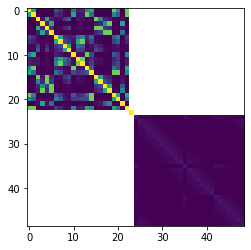

In [55]:
# build the prior covariance matrix and store it as a compresed bianry file (otherwise it can get huge!)
if pf.pst.npar < 35000:  #if you have more than about 35K pars, the cov matrix becomes hard to handle
    cov = pf.build_prior(fmt='coo', filename=os.path.join(template_ws,"prior_cov.jcb"))
    # and take a peek at a slice of the matrix
    try: 
        x = cov.x.copy()
        x[x==0] = np.NaN
        plt.imshow(x[-49:,-49:])
    except:
        pass

And now generate a prior parameter ensemble. This step is relevant for using pestpp-ies in subsequent tutorials.

In [56]:
pe = pf.draw(num_reals=100, use_specsim=True) # draw parameters from the prior distribution
pe.enforce() # enforces parameter bounds
pe.to_binary(os.path.join(template_ws,"prior_pe.jcb")) #writes the paramter ensemble to binary file

# final tidy-up
pst.pestpp_options["ies_parameter_ensemble"] = "prior_pe.jcb" #adds pest++ options to the control file
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst')) # re-writes the control file with the new pest++ options

2022-03-17 12:42:25.363036 starting: drawing realizations
2022-03-17 12:42:25.534611 starting: spectral simulation for grid-scale pars


SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:25.750999 starting: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:25.798923 finished: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.047924
2022-03-17 12:42:25.802861 starting: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72


2022-03-17 12:42:25.849735 finished: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046874
2022-03-17 12:42:25.854773 starting: SpecSim: drawing 100 realization for group npf_k_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:25.900601 finished: SpecSim: drawing 100 realization for group npf_k_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045828
2022-03-17 12:42:25.906613 starting: SpecSim: drawing 100 realization for group npf_k33_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:25.954455 finished: SpecSim: drawing 100 realization for group npf_k33_layer1_gr with 706 pars, (log) variance 0.0542

2022-03-17 12:42:26.057180 finished: SpecSim: drawing 100 realization for group npf_k33_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046875
2022-03-17 12:42:26.062167 starting: SpecSim: drawing 100 realization for group sto_ss_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:26.109041 finished: SpecSim: drawing 100 realization for group sto_ss_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046874
2022-03-17 12:42:26.113030 starting: SpecSim: drawing 100 realization for group sto_ss_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:26.158959 finished: SpecSim: drawing 100 realization for group sto_ss_layer3_gr with 706 pars, (log) variance 0.05

2022-03-17 12:42:26.260727 finished: SpecSim: drawing 100 realization for group rch_recharge_1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046930
2022-03-17 12:42:26.264712 starting: SpecSim: drawing 100 realization for group rch_recharge_10_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:26.311568 finished: SpecSim: drawing 100 realization for group rch_recharge_10_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046856
2022-03-17 12:42:26.315560 starting: SpecSim: drawing 100 realization for group rch_recharge_11_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:26.362436 finished: SpecSim: drawing 100 realization for group rch_recharge_11_gr with 706 pars, (log) varia

2022-03-17 12:42:26.464128 finished: SpecSim: drawing 100 realization for group rch_recharge_13_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.047873
2022-03-17 12:42:26.468117 starting: SpecSim: drawing 100 realization for group rch_recharge_14_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:26.514992 finished: SpecSim: drawing 100 realization for group rch_recharge_14_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046875
2022-03-17 12:42:26.518981 starting: SpecSim: drawing 100 realization for group rch_recharge_15_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:26.565933 finished: SpecSim: drawing 100 realization for group rch_recharge_15_gr with 706 pars, (log) vari

2022-03-17 12:42:26.666627 finished: SpecSim: drawing 100 realization for group rch_recharge_17_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045797
2022-03-17 12:42:26.670829 starting: SpecSim: drawing 100 realization for group rch_recharge_18_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:26.717526 finished: SpecSim: drawing 100 realization for group rch_recharge_18_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046697
2022-03-17 12:42:26.721513 starting: SpecSim: drawing 100 realization for group rch_recharge_19_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:26.767394 finished: SpecSim: drawing 100 realization for group rch_recharge_19_gr with 706 pars, (log) vari

2022-03-17 12:42:26.869086 finished: SpecSim: drawing 100 realization for group rch_recharge_20_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046842
2022-03-17 12:42:26.874125 starting: SpecSim: drawing 100 realization for group rch_recharge_21_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:26.920948 finished: SpecSim: drawing 100 realization for group rch_recharge_21_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046823
2022-03-17 12:42:26.924968 starting: SpecSim: drawing 100 realization for group rch_recharge_22_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:26.971862 finished: SpecSim: drawing 100 realization for group rch_recharge_22_gr with 706 pars, (log) vari

2022-03-17 12:42:27.074536 finished: SpecSim: drawing 100 realization for group rch_recharge_24_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046875
2022-03-17 12:42:27.079523 starting: SpecSim: drawing 100 realization for group rch_recharge_25_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:27.126449 finished: SpecSim: drawing 100 realization for group rch_recharge_25_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046926
2022-03-17 12:42:27.131384 starting: SpecSim: drawing 100 realization for group rch_recharge_3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:27.177923 finished: SpecSim: drawing 100 realization for group rch_recharge_3_gr with 706 pars, (log) varian

2022-03-17 12:42:27.281593 finished: SpecSim: drawing 100 realization for group rch_recharge_5_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046875
2022-03-17 12:42:27.285583 starting: SpecSim: drawing 100 realization for group rch_recharge_6_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:27.330513 finished: SpecSim: drawing 100 realization for group rch_recharge_6_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.044930
2022-03-17 12:42:27.334452 starting: SpecSim: drawing 100 realization for group rch_recharge_7_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:27.379383 finished: SpecSim: drawing 100 realization for group rch_recharge_7_gr with 706 pars, (log) variance 

SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-17 12:42:27.671604 finished: spectral simulation for grid-scale pars took: 0:00:02.136993
2022-03-17 12:42:27.671604 starting: Drawing non-specsim pars
building diagonal cov


processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['npf_k_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k_layer3_pp']
build cov matrix


done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k33_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['npf_k33_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k33_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['sto_ss_layer2_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['sto_ss_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['sto_sy_layer1_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_10_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_11_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_12_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_13_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_14_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_15_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_16_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_17_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_18_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_19_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_20_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_21_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_22_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_23_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_24_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_25_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_3_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_4_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_5_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_6_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_7_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_8_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_9_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov


working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['sfrcond_gr']
build cov matrix
done
getting diag var cov 40
scaling full cov by diag var cov


processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

working on pargroups ['wel_cst']
build cov matrix
done
getting diag var cov 25
scaling full cov by diag var cov
working on pargroups ['sfr_gr']
build cov matrix
done
getting diag var cov 25
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov


working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
adding remaining parameters to diagonal


2022-03-17 12:42:35.018515 finished: Drawing non-specsim pars took: 0:00:07.346911


2022-03-17 12:42:37.105245 finished: drawing realizations took: 0:00:11.742209


noptmax:0, npar_adj:25454, nnz_obs:920
